# TC El NIno diagnostics

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
#import geocat.comp
from geocat.viz import util as gvutil
import datetime
from cftime import DatetimeNoLeap

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

import cf_units as cf

In [2]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(
        orig_units.convert, ds[variable_bounds_str], target_units,
        output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units


def calculate_ohc(temperature, delta_z, z_t, z_str, z_limit):
    rho = 1026   # kg/m3
    c = 3900     # J/(kg K)
    delta_limit = delta_z.where(z_t < z_limit,drop=True)
    temperature_limit = temperature.where(z_t<z_limit, drop=True)
    print(temperature_limit.shape)
    weighted_temp= temperature_limit * delta_limit
    ohc = rho * c *  weighted_temp.sum(dim=z_str)
    return ohc

## 1. get PDO and nino index for control

In [3]:
# area for nino3.4
latS = -5.5
latN = 5.5
lonL = 190.
lonR = 241.
nrun = 3

In [4]:
# area for nino3
latS3 = -5.5
latN3 = 5.5
lonL3 = 210.
lonR3 = 271.

In [5]:
# area for nino4
latS4 = -5.5
latN4 = 5.5
lonL4 = 160.
lonR4 = 210.


### read in date from control run

In [6]:
dst = xr.open_dataset("/glade/campaign/cgd/ccr/huili7/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010./b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.SST.0301-0400.1x1.nc")
TS = dst.TEMP[:,0,:,:]

time = TS.time
lat= TS['lat']
lon = TS['lon']
ntime = np.size(time)
nlat  = np.size(lat)
nlon = np.size(lon)

### get PDO for control

In [7]:
# get latidudinal weight
wgt = np.cos(np.deg2rad(TS.lat))


In [8]:
wgt2d = wgt.expand_dims({'lon':TS.lon.data})

In [9]:
# get monthly climatology
monclm0 = TS.groupby(TS.time.dt.month).mean('time')

In [10]:
# get anomalies to climatology
sstanom0 = TS.groupby(TS.time.dt.month) - monclm0
sstanom0

<xarray.DataArray 'TEMP' (time: 1200, lat: 180, lon: 360)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 4.22239304e-04,  4.15563583e-04,  4.10437584e-04, ...,
          4.52518463e-04,  4.40120697e-04,  4.28676605e-04],
        [ 7.49945641e-04,  7.43746758e-04,  7.37309456e-04, ...,
          7.70688057e-04,  7.63058662e-04,  7.56502151e-04],
        [ 2.82764435e-04,  2.76088715e-04,  2.69532204e-04, ...,
          3.03149223e-04,  2.96711922e-04,  2.89678574e-04]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
          6.62207603e-04,  6.67452812e-04,  6.71148300e-04],
        [ 2.28404999e-04,  2.58803368e-04,  2.88724899e-04, ...,
          1.31964684e-04,  1.64508820e-04,  1.96814537e-04],
        [-1.19090080e-04, -1.12533569e-04, -1.05738640e-04, ...,
         -1.37567520e-04, -1.31368637e-04, -1.25288963e-04]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 1.53660774e-04,  2.24709511e-04,  3.00526619e-04, ...,
         -1.03712082e-05,  3.52859497e-05,  8.72612000e-05],
        [ 3.07321548e-04,  3.17335129e-04,  3.27467918e-04, ...,
          2.81810760e-04,  2.89320946e-04,  2.97904015e-04],
        [ 2.89678574e-05,  2.88486481e-05,  2.83718109e-05, ...,
          3.17096710e-05,  3.05175781e-05,  2.98023224e-05]]],
      dtype=float32)
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0401-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [11]:
# get anomaly from average pacific 
sstpdo0 = sstanom0 - (wgt2d.sel(lat=slice(-60,70)) * sstanom0.sel(lat=slice(-60,70))).mean(('lat','lon'))

In [12]:
# start eof analysis
# 1. import geocat eof functions
 
from geocat.comp import eofunc_eofs, eofunc_pcs

In [13]:
# 2. get latitudial weight before analysis 
clat = np.sqrt(np.cos(np.deg2rad(TS.lat)))
sstpdo0 = sstpdo0 * clat



In [14]:
# 3. apply eof to north Pacific

eofs0 = eofunc_eofs(sstpdo0.sel(lat=slice(20,70),lon=slice(110,260)).data, neofs=2, meta=True)
pcs0 = eofunc_pcs(sstpdo0.sel(lat=slice(20,70),lon=slice(110,260)).data, npcs=2, meta=True)
pcs0 = pcs0 / pcs0.std(dim='time')
pcs0['time']=sstpdo0['time']
pcs0.attrs['varianceFraction'] = eofs0.attrs['varianceFraction']
print(pcs0)



<xarray.DataArray 'pcs' (pc: 2, time: 1200)>
array([[-0.8325624 , -1.13946285, -1.1853402 , ...,  0.3927561 ,
         0.50356485, -0.11281242],
       [-0.08964863,  0.33081641,  0.79127604, ..., -0.65777262,
        -0.06786195,  0.15527418]])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0401-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: pc
Attributes:
    varianceFraction:  <xarray.DataArray 'variance_fractions' (mode: 2)>\narr...


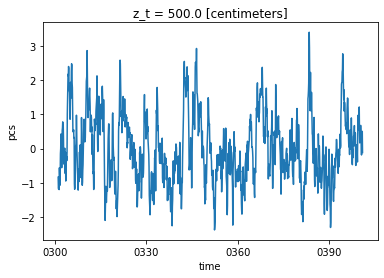

In [15]:
pcs0[0].plot()

### get nino index for control, nino 3.4

In [16]:
# get nino index
xClm =TS.groupby(TS.time.dt.month).mean()
xAnom = TS.groupby(TS.time.dt.month) - xClm

# nino3.4
xAnom_avg = xAnom.sel(lat=slice(latS,latN),lon=slice(lonL,lonR)).mean(('lat','lon')).rolling(time=nrun, center=True).mean()
# nino3
xAnom_avg_nino3 = xAnom.sel(lat=slice(latS3,latN3),lon=slice(lonL3,lonR3)).mean(('lat','lon')).rolling(time=nrun, center=True).mean()
# nino4
xAnom_avg_nino4 = xAnom.sel(lat=slice(latS4,latN4),lon=slice(lonL4,lonR4)).mean(('lat','lon')).rolling(time=nrun, center=True).mean()



In [17]:
nino_ndj0 = xAnom_avg.isel(time=xAnom_avg.time.dt.month.isin(12))
nino_ond0_nino3 = xAnom_avg_nino3.isel(time=xAnom_avg_nino3.time.dt.month.isin(11))
nino_ndj0_nino3 = xAnom_avg_nino3.isel(time=xAnom_avg_nino3.time.dt.month.isin(12))
nino_ndj0_nino4 = xAnom_avg_nino4.isel(time=xAnom_avg_nino4.time.dt.month.isin(12))

ninoyear0 = nino_ndj0.where(nino_ndj0>=1,drop=True).time.dt.year
ninoyear0

<xarray.DataArray 'year' (time: 18)>
array([303, 304, 309, 310, 313, 314, 322, 328, 339, 342, 346, 349, 363,
       366, 368, 372, 377, 383])
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0383-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

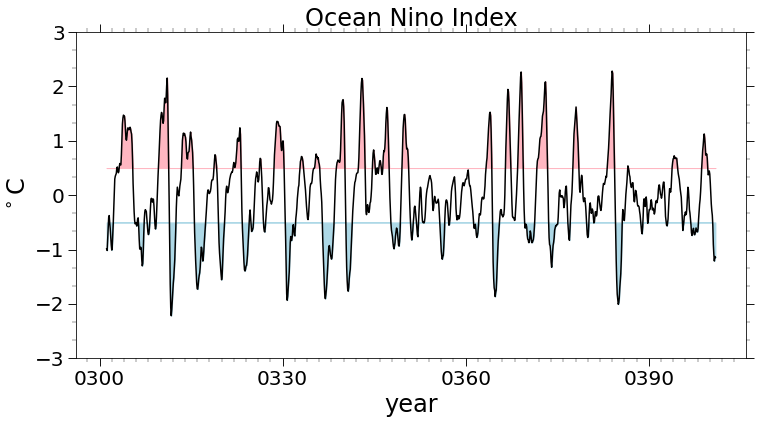

In [18]:
fig,ax = plt.subplots(figsize=(12,6))
x = xAnom_avg.time.dt.year

xAnom_min = np.random.rand(ntime)
xAnom_min[:] = -0.5
xAnom_max = np.random.rand(ntime)
xAnom_max[:] = 0.5

ax.plot(xAnom_avg.time,xAnom_avg,color='black',label='ONI')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-3., 3.))
ax.fill_between(xAnom_avg.time.values, xAnom_min, np.min([xAnom_avg.data,xAnom_min],axis=0), color='lightblue', zorder=0)
ax.fill_between(xAnom_avg.time.values, xAnom_max, np.max([xAnom_avg.data,xAnom_max],axis=0), color='lightpink', zorder=1)

ax.set_title('Ocean Nino Index', fontsize=24)#, pad=60.0)
ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)
c
# overlay pdo index
#ax.plot(pcs0.time[:],pcs0[0].rolling(time=61,center=True).mean('time'),color='blue')


plt.savefig('oni_pdo_index_control.pdf')

### plot  nino3 vs nino4


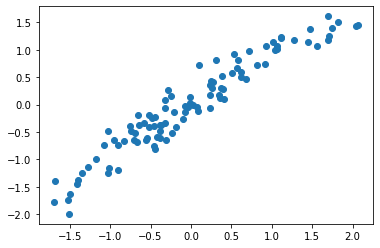

In [19]:
plt.scatter(nino_ndj0_nino3, nino_ndj0_nino4)

## 2.get PDO and nino index for TC run

In [20]:
dst_tc = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.SST.0301-0473.1x1.nc")
TS2 = dst_tc.TEMP[:,0,:,:]
# we need to fix the data.there are two years of 330

In [21]:
TS_TC1 = TS2[0:360].copy(data=TS2[0:360])
TS_TC2 = TS2[372:2088].copy(data=TS2[372:2088])

In [22]:
TS_TC = xr.concat([TS_TC1, TS_TC2],dim='time')

In [23]:
tropics2 = TS_TC.sel(lat=slice(latS,latN),lon=slice(lonL,lonR))
time2 = tropics2.time
ntime2 = np.size(time2)
TS_TC

<xarray.DataArray 'TEMP' (time: 2076, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.8012192, -1.8012637, -1.801306 , ..., -1.8010464,
         -1.8011119, -1.8011729],
        [-1.7995615, -1.7995709, -1.7995782, ..., -1.7995216,
         -1.799537 , -1.7995503],
        [-1.799272 , -1.7992713, -1.7992706, ..., -1.7992727,
         -1.7992725, -1.7992723]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.8003415, -1.8004179, -1.8004959, ..., -1.8001391,
         -1.8002006, -1.8002664],
        [-1.8007834, -1.8008058, -1.8008286, ..., -1.8007184,
         -1.8007398, -1.8007613],
        [-1.8004459, -1.8004501, -1.8004545, ..., -1.8004335,
         -1.8004376, -1.8004416]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.8001474, -1.8001277, -1.8001095, ..., -1.8002177,
         -1.8001928, -1.8001686],
        [-1.8005127, -1.8005013, -1.8004901, ..., -1.8005466,
         -1.8005353, -1.8005239],
        [-1.8009113, -1.8009199, -1.8009284, ..., -1.8008859,
         -1.8008944, -1.8009028]]], dtype=float32)
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0474-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

### get PDO index for TC run

In [24]:
# get latidudinal weight
wgt = np.cos(np.deg2rad(TS_TC.lat))


In [70]:
wgt2d = wgt.expand_dims({'lon':TS2.lon.data})

In [71]:
# get monthly climatology
monclm = TS_TC.groupby(TS_TC.time.dt.month).mean('time')

In [29]:
# get anomaly to climatology
sstanom = TS_TC.groupby(TS_TC.time.dt.month) - monclm
sstanom

<xarray.DataArray 'TEMP' (time: 2076, lat: 180, lon: 360)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [-1.7354488e-03, -1.7853975e-03, -1.8326044e-03, ...,
         -1.5447140e-03, -1.6163588e-03, -1.6828775e-03],
        [-8.4877014e-05, -9.9778175e-05, -1.1074543e-04, ...,
         -3.3855438e-05, -5.2809715e-05, -6.9856644e-05],
        [ 2.7275085e-04,  2.7155876e-04,  2.7012825e-04, ...,
          2.7894974e-04,  2.7811527e-04,  2.7501583e-04]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [-4.4810772e-04, -5.3155422e-04, -6.1678886e-04, ...,
         -2.3186207e-04, -2.9706955e-04, -3.6644936e-04],
        [-9.0813637e-04, -9.3281269e-04, -9.5832348e-04, ...,
         -8.3422661e-04, -8.5830688e-04, -8.8346004e-04],
        [-6.5708160e-04, -6.6184998e-04, -6.6602230e-04, ...,
         -6.4313412e-04, -6.4730644e-04, -6.5159798e-04]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [-4.9269199e-04, -4.8041344e-04, -4.6813488e-04, ...,
         -5.4311752e-04, -5.2571297e-04, -5.0818920e-04],
        [-7.9703331e-04, -7.8964233e-04, -7.8284740e-04, ...,
         -8.1694126e-04, -8.1050396e-04, -8.0275536e-04],
        [-1.1548996e-03, -1.1649132e-03, -1.1751652e-03, ...,
         -1.1223555e-03, -1.1330843e-03, -1.1438131e-03]]], dtype=float32)
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0474-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [30]:
# get anomaly from average pacific 
sstpdo = sstanom - (wgt2d.sel(lat=slice(-60,70)) * sstanom.sel(lat=slice(-60,70))).mean(('lat','lon'))

In [31]:
# 2. get latitudial weight before analysis 
#clat = np.sqrt(np.cos(np.deg2rad(TS.lat)))
sstpdo = sstpdo * clat



In [32]:
# 3. apply eof to north Pacific

eofs = eofunc_eofs(sstpdo.sel(lat=slice(20,70),lon=slice(110,260)).data, neofs=2, meta=True)
pcs = eofunc_pcs(sstpdo.sel(lat=slice(20,70),lon=slice(110,260)).data, npcs=2, meta=True)
pcs = pcs / pcs.std(dim='time')
pcs['time']=sstpdo['time']
pcs.attrs['varianceFraction'] = eofs.attrs['varianceFraction']
print(pcs)



<xarray.DataArray 'pcs' (pc: 2, time: 2076)>
array([[-0.86795709, -1.00242257, -0.42113788, ...,  0.38940479,
         0.86190618,  0.67179392],
       [ 0.30817558,  0.01552561, -0.19932099, ...,  2.91773774,
         2.48447213,  2.7261974 ]])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0474-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1
Dimensions without coordinates: pc
Attributes:
    varianceFraction:  <xarray.DataArray 'variance_fractions' (mode: 2)>\narr...


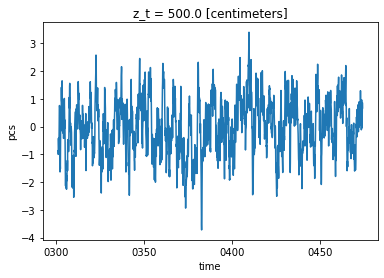

In [33]:
pcs[0].plot()

### get nino index for TC run

In [25]:
# get nino index
xClm2 =TS_TC.groupby(TS_TC.time.dt.month).mean()
xAnom2 = TS_TC.groupby(TS_TC.time.dt.month) - xClm2

# nino3.4
xAnom_avg2 = xAnom2.sel(lat=slice(latS,latN),lon=slice(lonL,lonR)).mean(('lat','lon')).rolling(time=nrun, center=True).mean()
# nino3
xAnom_avg2_nino3 = xAnom2.sel(lat=slice(latS3,latN3),lon=slice(lonL3,lonR3)).mean(('lat','lon')).rolling(time=nrun, center=True).mean()
# nino4
xAnom_avg2_nino4 = xAnom2.sel(lat=slice(latS4,latN4),lon=slice(lonL4,lonR4)).mean(('lat','lon')).rolling(time=nrun, center=True).mean()



In [26]:
nino_ndj = xAnom_avg2.isel(time=xAnom_avg2.time.dt.month.isin(12))
nino_ndj_nino3 = xAnom_avg2_nino3.isel(time=xAnom_avg2_nino3.time.dt.month.isin(12))
nino_ond_nino3 = xAnom_avg2_nino3.isel(time=xAnom_avg2_nino3.time.dt.month.isin(11))
nino_ndj_nino4 = xAnom_avg2_nino4.isel(time=xAnom_avg2_nino4.time.dt.month.isin(12))

ninoyear = nino_ndj.where(nino_ndj>=1,drop=True).time.dt.year
ninoyear

<xarray.DataArray 'year' (time: 35)>
array([302, 303, 306, 315, 318, 322, 326, 336, 341, 356, 359, 365, 366,
       369, 375, 379, 380, 389, 392, 402, 408, 409, 413, 419, 426, 429,
       430, 433, 434, 435, 442, 447, 454, 463, 472])
Coordinates:
  * time     (time) object 0302-12-01 00:00:00 ... 0472-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

Text(0.5, 0, 'year')

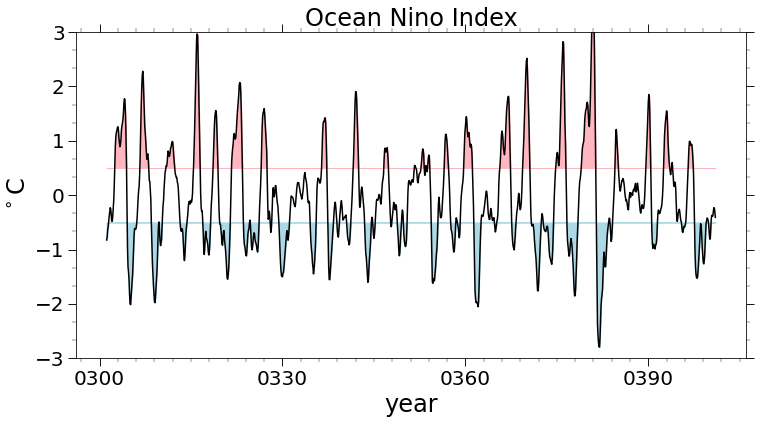

In [27]:

fig,ax = plt.subplots(1,1,figsize=(12,6))

x = xAnom_avg2.time.dt.year

xAnom_min2 = np.random.rand(ntime2)
xAnom_min2[:] = -0.5
xAnom_max2 = np.random.rand(ntime2)
xAnom_max2[:] = 0.5


ax.plot(xAnom_avg2.time[0:1200],xAnom_avg2[0:1200],color='black',label='ONI')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=10, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-3., 3.))
ax.fill_between(xAnom_avg2[0:1200].time.values, xAnom_min2[0:1200], np.min([xAnom_avg2[0:1200].data,xAnom_min2[0:1200]],axis=0), color='lightblue', zorder=0)
ax.fill_between(xAnom_avg2[0:1200].time.values, xAnom_max2[0:1200], np.max([xAnom_avg2[0:1200].data,xAnom_max2[0:1200]],axis=0), color='lightpink', zorder=1)

ax.set_title('Ocean Nino Index', fontsize=24)#, pad=60.0)
ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)
# overlay pdo index
#ax.plot(pcs.time[0:1200],pcs[0,0:1200].rolling(time=61,center=True).mean('time'),color='blue')

#plt.savefig('oni_pdo_index_tc_300-400.pdf')

In [28]:
import cftime
import datetime


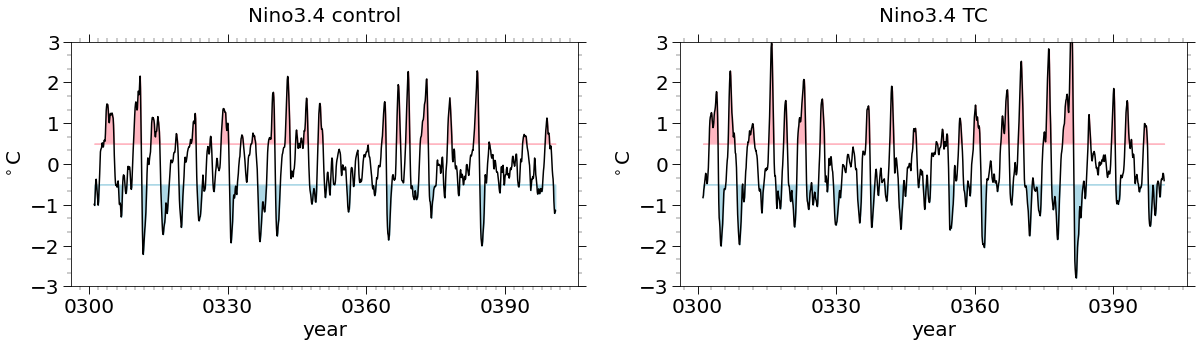

In [29]:

fig,ax = plt.subplots(1,2,figsize=(20,4.5))

#x1 = xAnom_avg.time  - datetime.timedelta(days=299*365)
#x2 = xAnom_avg2.time.dt.year

xAnom_min2 = np.random.rand(ntime2)
xAnom_min2[:] = -0.5
xAnom_max2 = np.random.rand(ntime2)
xAnom_max2[:] = 0.5


ax[0].plot(xAnom_avg.time,xAnom_avg,color='black',label='ONI')
gvutil.add_major_minor_ticks(ax[0], x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax[0],ylim=(-3., 3.))



ax[0].fill_between(xAnom_avg.time.values, xAnom_min, np.min([xAnom_avg.data,xAnom_min],axis=0), color='lightblue', zorder=0)
ax[0].fill_between(xAnom_avg.time.values, xAnom_max, np.max([xAnom_avg.data,xAnom_max],axis=0), color='lightpink', zorder=1)

ax[0].set_title('Nino3.4 control', fontsize=20, pad=20.0)
ax[0].set_ylabel('$^\circ$C', fontsize=20)
ax[0].set_xlabel('year',fontsize=20)




ax[1].plot(xAnom_avg2.time[0:1200],xAnom_avg2[0:1200],color='black',label='ONI')
gvutil.add_major_minor_ticks(ax[1], x_minor_per_major=10, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax[1],ylim=(-3., 3.))
ax[1].fill_between(xAnom_avg2[0:1200].time.values, xAnom_min2[0:1200], np.min([xAnom_avg2[0:1200].data,xAnom_min2[0:1200]],axis=0), color='lightblue', zorder=0)
ax[1].fill_between(xAnom_avg2[0:1200].time.values, xAnom_max2[0:1200], np.max([xAnom_avg2[0:1200].data,xAnom_max2[0:1200]],axis=0), color='lightpink', zorder=1)

ax[1].set_title('Nino3.4 TC', fontsize=20, pad=20.0)
ax[1].set_ylabel('$^\circ$C', fontsize=20)
ax[1].set_xlabel('year',fontsize=20)
# overlay pdo index
#ax.plot(pcs.time[0:1200],pcs[0,0:1200].rolling(time=61,center=True).mean('time'),color='blue')

plt.savefig('oni_index_2panels_300-400.pdf')

In [37]:
xAnom_avg2.to_netcdf('tc_run_nino_index_301-474.nc')

### plot nino3 vs nino4 for TC run

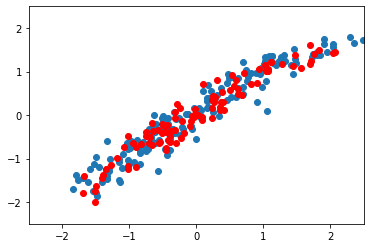

In [18]:
plt.scatter(nino_ndj_nino3, nino_ndj_nino4)
plt.axis([-2.5, 2.5, -2.5, 2.5])

plt.scatter(nino_ndj0_nino3, nino_ndj0_nino4, color='red' )

### 2.1 plot nino statistics from cvdp diagnostic

In [30]:
cvdp0 = xr.open_dataset('/glade/work/huili7/diagnostics/CVDP/output/TC_run_330-473/CONTROL.cvdp_data.301-400.nc',decode_times=False)
cvdp = xr.open_dataset('/glade/work/huili7/diagnostics/CVDP/output/TC_run_330-473/TC_RUN.cvdp_data.330-473.nc',decode_times=False)
cvdp_obs = xr.open_dataset('/glade/work/huili7/diagnostics/CVDP/output/output_obs/ERSST_v5.cvdp_data.1920-2018.nc',decode_times=False)

In [31]:
cvdp_highres = xr.open_dataset('/glade/work/huili7/TC-Ocean/highres_sst_indices.nc',decode_times=False)
cvdp_highres

<xarray.Dataset>
Dimensions:                (time: 1200, ncurves: 4, frequency: 600, time_mon2: 12)
Coordinates:
  * time                   (time) float64 396.0 424.0 ... 3.683e+04 3.686e+04
  * ncurves                (ncurves) int32 0 1 2 3
  * frequency              (frequency) float32 0.0008333 0.001667 ... 0.4992 0.5
  * time_mon2              (time_mon2) int32 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    nino34                 (time) float32 ...
    nino34_spectra         (ncurves, frequency) float32 ...
    nino34_monthly_stddev  (time_mon2) float32 ...

In [32]:
cvdp_ihesp = xr.open_dataset('/glade/work/huili7/iHesp/ihesp_sst_indices_250-337_01x01.nc',decode_times=False)
cvdp_ihesp

<xarray.Dataset>
Dimensions:                (time: 1056, ncurves: 4, frequency: 528, time_mon2: 12)
Coordinates:
  * time                   (time) float64 9.092e+04 9.094e+04 ... 1.23e+05
  * ncurves                (ncurves) int32 0 1 2 3
  * frequency              (frequency) float32 0.000947 0.001894 ... 0.4991 0.5
  * time_mon2              (time_mon2) int32 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    nino34                 (time) float32 ...
    nino34_spectra         (ncurves, frequency) float32 ...
    nino34_monthly_stddev  (time_mon2) float32 ...

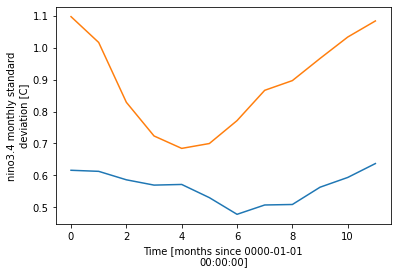

In [33]:
cvdp_ihesp.nino34_monthly_stddev.plot()
cvdp0.nino34_monthly_stddev.plot()

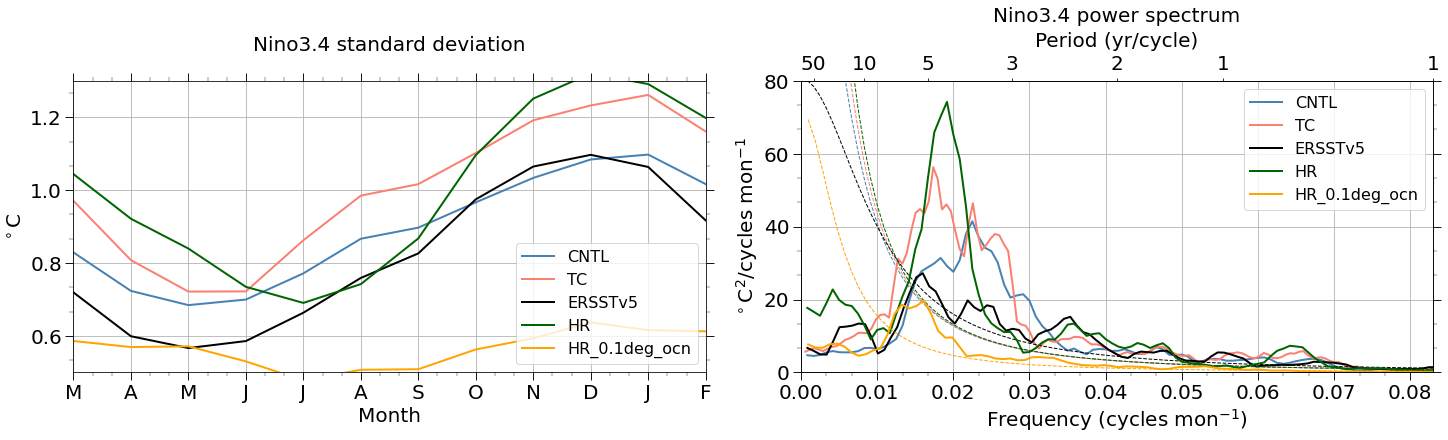

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)


#fig,ax = plt.subplots(figsize=(10,6))
x = np.arange(1,13)

ax[0].plot(x,cvdp0.nino34_monthly_stddev.roll(time_mon2=-2),color='steelblue',linewidth=2.,label='CNTL')
ax[0].plot(x,cvdp.nino34_monthly_stddev.roll(time_mon2=-2),color='salmon',linewidth=2,label='TC')
ax[0].plot(x,cvdp_obs.nino34_monthly_stddev.roll(time_mon2=-2),color='black',linewidth=2,label='ERSSTv5')
ax[0].plot(x,cvdp_highres.nino34_monthly_stddev.roll(time_mon2=-2),color='darkgreen',linewidth=2,label='HR')
ax[0].plot(x,cvdp_ihesp.nino34_monthly_stddev.roll(time_mon2=-2),color='orange',linewidth=2,label='HR_0.1deg_ocn')

gvutil.set_axes_limits_and_ticks(ax[0],ylim=(.5, 1.3),xlim=(1,12),xticks=x,xticklabels=['M','A','M','J','J','A','S','O','N','D','J','F'])
gvutil.add_major_minor_ticks(ax[0], labelsize=20)

ax[0].set_title('Nino3.4 standard deviation', fontsize=20, pad=30.0)
ax[0].set_ylabel('$^\circ$C', fontsize=20)
ax[0].set_xlabel('Month',fontsize=20)
ax[0].grid(True)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels,fontsize=16,loc="lower right")
#----------

#ax.set_yscale('log')
ax[1].plot(cvdp0.nino34_spectra.frequency,cvdp0.nino34_spectra[0,:],color='steelblue',linewidth=2,label='CNTL')
ax[1].plot(cvdp0.nino34_spectra.frequency,cvdp0.nino34_spectra[2,:],color='steelblue',linewidth=1,linestyle='--')

ax[1].plot(cvdp.nino34_spectra.frequency,cvdp.nino34_spectra[0,:],color='salmon',linewidth=2,label='TC')
ax[1].plot(cvdp.nino34_spectra.frequency,cvdp.nino34_spectra[2,:],color='salmon',linewidth=1,linestyle='--')

ax[1].plot(cvdp_obs.nino34_spectra.frequency,cvdp_obs.nino34_spectra[0,:],color='black',linewidth=2,label='ERSSTv5')
ax[1].plot(cvdp_obs.nino34_spectra.frequency,cvdp_obs.nino34_spectra[2,:],color='black',linewidth=1, linestyle='--')

ax[1].plot(cvdp_highres.nino34_spectra.frequency,cvdp_highres.nino34_spectra[0,:],color='darkgreen',linewidth=2,label='HR')
ax[1].plot(cvdp_highres.nino34_spectra.frequency,cvdp_highres.nino34_spectra[2,:],color='darkgreen',linewidth=1,linestyle='--')

ax[1].plot(cvdp_ihesp.nino34_spectra.frequency,cvdp_ihesp.nino34_spectra[0,:],color='orange',linewidth=2,label='HR_0.1deg_ocn')
ax[1].plot(cvdp_ihesp.nino34_spectra.frequency,cvdp_ihesp.nino34_spectra[2,:],color='orange',linewidth=1,linestyle='--')


ax[1].grid(True)

xticks=np.array([.00167,.00833,.01667,.02778,.0416,.0556,.0832])
gvutil.set_axes_limits_and_ticks(ax[1],xlim=(0,0.083))#,xticks=[.00167,.00833,.01667,.02778,.0416,.0556,.0832],xticklabels=xticks)
gvutil.add_major_minor_ticks(ax[1], labelsize=20)

# set upper label
ax2 = ax[1].twiny()
ax2.set_xlim(ax[1].get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels(np.round(1/(xticks*12)).astype(int),fontsize=20)
ax2.set_xlabel("Period (yr/cycle)",fontsize=20,labelpad=8)

ax[1].set_title('Nino3.4 power spectrum', fontsize=20, pad=10.0)
ax[1].set_ylim(0,80)
ax[1].set_ylabel('$^\circ$C$^{2}$/cycles mon$^{-1}$', fontsize=20)
ax[1].set_xlabel('Frequency (cycles mon$^{-1}$)',fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels,fontsize=16)
plt.savefig('nino_power.png')

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/gla

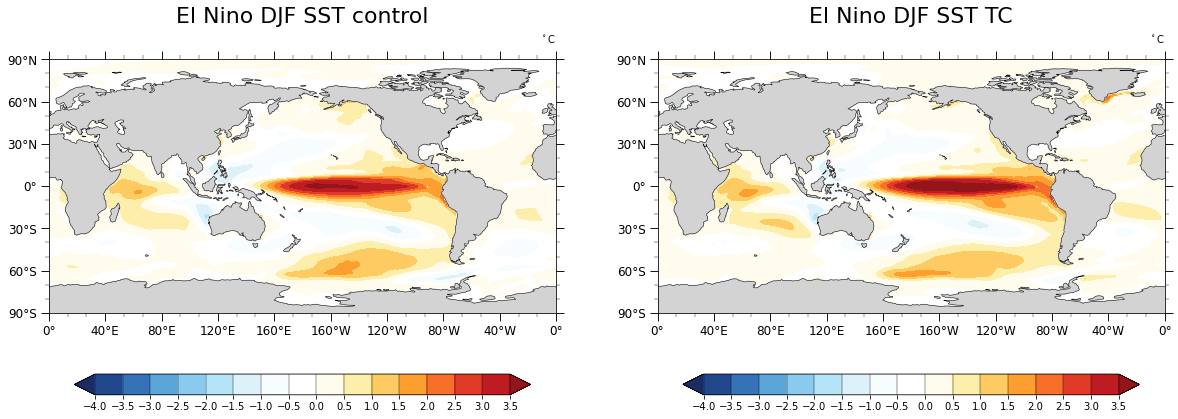

In [179]:
from geocat.viz import cmaps as gvcmaps

fig = plt.figure(figsize=(20, 15))
#fig.tight_layout(pad=-2)

#grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.85, 0.15],wspace=0.08)
#map_contour_plots(sfc_diff_ocn,2, 2, ax, 1, np.arange(-4,4.5,0.5), gvcmaps.BlueWhiteOrangeRed, "Radiative flux anomalies", "$W/m^2$")

ax = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
contour = cvdp0.nino34_spacomp_sst_djf1.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-4., 4., 0.5),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)


plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-4.5, 5, 20),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.9)



gvutil.set_titles_and_labels(ax,maintitle="El Nino DJF SST control",
                             maintitlefontsize=20,righttitle="$^\circ$C",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax, labelsize=12)


gvutil.add_lat_lon_ticklabels(ax)



#--------------
ax2 = plt.subplot(1,2,2,projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
contour2 = cvdp.nino34_spacomp_sst_djf1.plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-4., 4., 0.5),
                           extend='both',
                            cmap = gvcmaps.BlueWhiteOrangeRed,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)


plt.colorbar(contour2,
             ax=ax2,
             ticks=np.linspace(-4.5, 5, 20
                              ),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.9)



gvutil.set_titles_and_labels(ax2,maintitle="El Nino DJF SST TC",
                             maintitlefontsize=20,righttitle="$^\circ$C",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax2, labelsize=12)


gvutil.add_lat_lon_ticklabels(ax2)


plt.savefig("elnino_sst_2panels.png")

### 2.2 nino34 for observations

In [19]:
import pandas as pd

In [20]:
r = pd.read_fwf('/glade/work/huili7/S2S/nino34.long.data.1870-2020',header=None)

In [21]:
dates = pd.date_range('1870',periods=152,freq='1Y')

In [22]:
dates.year

Int64Index([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879,
            ...
            2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
           dtype='int64', length=152)

In [23]:
r = r.set_axis(dates.year, axis='index')
r = r.set_axis(np.arange(0,13),axis='columns')
r = r.transpose()

In [24]:
nino34_obs = []
for iy in np.arange(1921,2021):
    nino34_obs.append(r[iy][1:13].array.to_numpy())

In [25]:
ninoarray = xr.DataArray(nino34_obs,dims=['year','month'])

In [26]:
stacked = ninoarray.stack(time=('year','month'))

In [27]:
stacked['time'] = pd.date_range('19210101','20201231',freq='1M')
stacked.name = 'nino34'


In [28]:
xAnom_obs = stacked.groupby(stacked.time.dt.month) - stacked.groupby(stacked.time.dt.month).mean()
xAnom_obs = xAnom_obs.rolling(time=3, center=True).mean()

nino_ndj_obs = xAnom_obs.isel(time=xAnom_obs.time.dt.month.isin(12))

In [33]:
nino_ndj_obs.where(nino_ndj_obs>=1)

<xarray.DataArray 'nino34' (time: 100)>
array([       nan,        nan,        nan,        nan, 1.4095    ,
              nan,        nan,        nan,        nan, 1.59616667,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 1.18616667,
       1.05283333,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 1.2995    ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 1.4095    ,
              nan,        nan,        nan,        nan,        nan,
              nan, 1.92283333,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 2.3095    ,        nan,        nan,        nan,
       1.10283333, 1.04283333,        nan,        nan,        nan,
       1.48616667,        nan,        nan, 1.18283333,        nan,
              nan, 2.41616667,        nan,        nan,        nan,
              nan, 1.2995    ,        nan,        nan,        nan,
              nan,        nan,        nan, 1.6095    ,        nan,
              nan,        nan,        nan,        nan, 2.59616667,
              nan,        nan,        nan,        nan,        nan])
Coordinates:
  * time     (time) datetime64[ns] 1921-12-31 1922-12-31 ... 2020-12-31
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

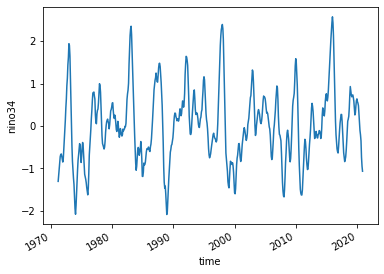

In [33]:
xAnom_obs.plot()

## 3. TC PDI

In [29]:
ft = xr.open_dataset('/glade/work/huili7/TC-Ocean/trajectory_file_330-474.nc')

In [30]:
ft2 = xr.open_dataset('/glade/work/huili7/trajectory_file_301-329.nc')

#### first trajectories form 301-330

In [31]:
traj_data0 = ft2.traj_data
wind0 = traj_data0[:,4,:]
traj0 = traj_data0.where(wind0>10, drop=True)

In [32]:
traj_data0

<xarray.DataArray 'traj_data' (nstorm: 2927, var: 10, steps: 185)>
[5414950 values with dtype=float32]
Dimensions without coordinates: nstorm, var, steps

In [33]:
lon0 = traj0[:,1,:]
lat0 = traj0[:,2,:]
traj_wp0 = traj0.where((lon0<280) & (lon0>120), drop = True)
traj_wp0

<xarray.DataArray 'traj_data' (nstorm: 1740, var: 10, steps: 179)>
array([[[ 3.0979900e+05,  3.0982500e+05,  3.0770300e+05, ...,
                    nan,            nan,            nan],
        [ 1.8170729e+02,  1.8375000e+02,  1.8729272e+02, ...,
                    nan,            nan,            nan],
        [-1.1037926e+01, -1.0478017e+01, -1.2444424e+01, ...,
                    nan,            nan,            nan],
        ...,
        [ 2.0000000e+00,  2.0000000e+00,  2.0000000e+00, ...,
                    nan,            nan,            nan],
        [ 1.0000000e+00,  1.0000000e+00,  2.0000000e+00, ...,
                    nan,            nan,            nan],
        [ 1.2000000e+01,  2.1000000e+01,  6.0000000e+00, ...,
                    nan,            nan,            nan]],

       [[ 3.0652100e+05,  3.0536000e+05,  3.0536100e+05, ...,
                    nan,            nan,            nan],
        [ 1.7829271e+02,  1.7154269e+02,  1.7175000e+02, ...,
                    nan,            nan,            nan],
        [-1.2744525e+01, -1.3358487e+01, -1.3365332e+01, ...,
                    nan,            nan,            nan],
...
        [ 1.2000000e+01,  1.2000000e+01,  1.2000000e+01, ...,
                    nan,            nan,            nan],
        [ 2.3000000e+01,  2.3000000e+01,  2.4000000e+01, ...,
                    nan,            nan,            nan],
        [ 1.8000000e+01,  2.1000000e+01,  6.0000000e+00, ...,
                    nan,            nan,            nan]],

       [[ 3.0119100e+05,  3.0119500e+05,  3.0119600e+05, ...,
                    nan,            nan,            nan],
        [ 1.8450000e+02,  1.8470731e+02,  1.8504272e+02, ...,
                    nan,            nan,            nan],
        [-1.6658651e+01, -1.6988541e+01, -1.6980549e+01, ...,
                    nan,            nan,            nan],
        ...,
        [ 1.2000000e+01,  1.2000000e+01,  1.2000000e+01, ...,
                    nan,            nan,            nan],
        [ 2.8000000e+01,  2.8000000e+01,  2.8000000e+01, ...,
                    nan,            nan,            nan],
        [ 6.0000000e+00,  9.0000000e+00,  1.2000000e+01, ...,
                    nan,            nan,            nan]]], dtype=float32)
Dimensions without coordinates: nstorm, var, steps

In [34]:
traj_twp0 = traj_wp0.where((traj_wp0[:,2,:]<15) & (traj_wp0[:,2,:]>-15), drop=True)


In [35]:
traj_wind0 = traj_wp0[:,4,:]
traj_wind0

<xarray.DataArray 'traj_data' (nstorm: 1740, steps: 179)>
array([[26.87675, 24.67701, 26.91801, ...,      nan,      nan,      nan],
       [20.34454, 23.06061, 22.65343, ...,      nan,      nan,      nan],
       [28.76071, 29.24351, 27.21472, ...,      nan,      nan,      nan],
       ...,
       [16.39726, 21.06865, 22.68419, ...,      nan,      nan,      nan],
       [27.66256, 25.52064, 30.0386 , ...,      nan,      nan,      nan],
       [28.81397, 30.00274, 30.14031, ...,      nan,      nan,      nan]],
      dtype=float32)
Dimensions without coordinates: nstorm, steps

In [36]:
traj_wind0.coords["year"] = traj_wp0[:,6,:]
traj_wind0.coords['month'] = traj_wp0[:,7,:]
traj_wind0.coords['lat'] = traj_wp0[:,2,:]
traj_wind0.coords['lon'] = traj_wp0[:,1,:]

In [37]:
traj_trop_wind0 = traj_twp0[:,4,:]
traj_trop_wind0.coords["year"] = traj_twp0[:,6,:]
traj_trop_wind0.coords['month'] = traj_twp0[:,7,:]
traj_trop_wind0.coords['lat'] = traj_twp0[:,2,:]
traj_trop_wind0.coords['lon'] = traj_twp0[:,1,:]

In [38]:
del traj_twp0
del traj_wp0

####  trajectorys from 330-473

In [39]:
traj_data = ft.traj_data
wind = traj_data[:,4,:]

In [40]:
traj  = traj_data.where(wind>10., drop=True)

In [41]:
lon = traj[:,1,:]
lat = traj[:,2,:]
traj_wp0 = traj.where(lon<280, drop = True)
traj_wp = traj_wp0.where(traj_wp0[:,1,:]>120, drop=True)
traj_wp

<xarray.DataArray 'traj_data' (nstorm: 8118, var: 10, steps: 103)>
array([[[ 2.9112600e+05,  2.9005100e+05,  2.9003500e+05, ...,
                    nan,            nan,            nan],
        [ 1.5600000e+02,  1.5579259e+02,  1.5470715e+02, ...,
                    nan,            nan,            nan],
        [-2.1938835e+01, -2.2101009e+01, -2.2433542e+01, ...,
                    nan,            nan,            nan],
        ...,
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
                    nan,            nan,            nan],
        [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00, ...,
                    nan,            nan,            nan],
        [ 0.0000000e+00,  6.0000000e+00,  1.8000000e+01, ...,
                    nan,            nan,            nan]],

       [[ 2.9861300e+05,  2.9861800e+05,  2.9969500e+05, ...,
                    nan,            nan,            nan],
        [ 1.4979262e+02,  1.4945721e+02,  1.4945721e+02, ...,
                    nan,            nan,            nan],
        [-1.6165796e+01, -1.5633588e+01, -1.5154847e+01, ...,
                    nan,            nan,            nan],
...
        [ 1.1000000e+01,  1.1000000e+01,  1.1000000e+01, ...,
                    nan,            nan,            nan],
        [ 2.1000000e+01,  2.2000000e+01,  2.2000000e+01, ...,
                    nan,            nan,            nan],
        [ 6.0000000e+00,  0.0000000e+00,  1.8000000e+01, ...,
                    nan,            nan,            nan]],

       [[ 3.3435000e+05,  3.3540400e+05,  3.3536500e+05, ...,
                    nan,            nan,            nan],
        [ 1.5750000e+02,  1.5545728e+02,  1.5170728e+02, ...,
                    nan,            nan,            nan],
        [ 6.2404051e+00,  6.3341112e+00,  6.6124959e+00, ...,
                    nan,            nan,            nan],
        ...,
        [ 1.2000000e+01,  1.2000000e+01,  1.2000000e+01, ...,
                    nan,            nan,            nan],
        [ 1.2000000e+01,  1.2000000e+01,  1.2000000e+01, ...,
                    nan,            nan,            nan],
        [ 0.0000000e+00,  6.0000000e+00,  1.8000000e+01, ...,
                    nan,            nan,            nan]]], dtype=float32)
Dimensions without coordinates: nstorm, var, steps

In [42]:
traj_twp0 = traj_wp.where(traj_wp[:,2,:]<15, drop=True)
traj_twp = traj_twp0.where(traj_twp0[:,2,:]>-15, drop=True)

In [43]:
traj_wind = traj_wp[:,4,:]
traj_wind

<xarray.DataArray 'traj_data' (nstorm: 8118, steps: 103)>
array([[20.23879, 20.42117, 20.6611 , ...,      nan,      nan,      nan],
       [24.83826, 27.76164, 25.6242 , ...,      nan,      nan,      nan],
       [23.47298, 28.13076, 21.19572, ...,      nan,      nan,      nan],
       ...,
       [22.49894, 21.09306, 24.54764, ...,      nan,      nan,      nan],
       [13.22874, 18.29602, 18.26429, ...,      nan,      nan,      nan],
       [30.90023, 26.67763, 33.62209, ...,      nan,      nan,      nan]],
      dtype=float32)
Dimensions without coordinates: nstorm, steps

In [44]:
traj_wind.coords["year"] = traj_wp[:,6,:]
traj_wind.coords['month'] = traj_wp[:,7,:]
traj_wind.coords['lat'] = traj_wp[:,2,:]
traj_wind.coords['lon'] = traj_wp[:,1,:]

In [113]:
traj_trop_wind = traj_twp[:,4,:]
traj_trop_wind.coords["year"] = traj_twp[:,6,:]
traj_trop_wind.coords['month'] = traj_twp[:,7,:]
traj_trop_wind.coords['day'] = traj_twp[:,8,:]
traj_trop_wind.coords['lat'] = traj_twp[:,2,:]
traj_trop_wind.coords['lon'] = traj_twp[:,1,:]


#### trajectories from observations

In [46]:
ft_obs = xr.open_dataset('/glade/work/huili7/ibtrack/tcdata_netcdf/gbtracks.nc')
ft_obs

<xarray.Dataset>
Dimensions:  (ns: 12741, bs: 180, chr: 26, time: 180)
Dimensions without coordinates: ns, bs, chr, time
Data variables:
    yearic   (ns) float64 ...
    basinic  (bs, ns) float64 ...
    nsic     (ns) float64 ...
    stnamec  (chr, ns) |S1 ...
    monthmc  (time, ns) float64 ...
    daymc    (time, ns) float64 ...
    hourmc   (time, ns) float64 ...
    latmc    (time, ns) float64 ...
    longmc   (time, ns) float64 ...
    vsmc     (time, ns) float64 ...
    pcmc     (time, ns) float64 ...

In [47]:
obs_year = ft_obs.yearic
obs_month = ft_obs.monthmc
obs_lat = ft_obs.latmc
obs_lon = ft_obs.longmc
obs_wind = ft_obs.vsmc

In [48]:
# tropical wind, May -Dec
obs_trop_wind = obs_wind.where((obs_lat>=-15) &(obs_lat<=15) & (obs_wind>0) & (obs_month>=5))

In [49]:
obs_trop_wind.coords['year'] = obs_year

In [50]:
obs_trop_wind.coords['lon'] = obs_lon

In [51]:
obs_trop_wind.coords['month'] = obs_month

###  3.1 calculate annual PDI, for the months leading to ENSO, May - Dec

In [52]:
ilon = np.arange(120,281,5)
ilat = np.arange(-50,55,5)
ilon.size

33

In [53]:
#pdi = xr.DataArray(data=np.zeros((144,21)),dims=['year','lat'])
pdi = xr.DataArray(data=np.zeros((173,33)),dims=['year','lon'])
pdi_obs = xr.DataArray(data=np.zeros((50,33)),dims=['year','lon'])   # 1971-2020

In [54]:
pdi['year'] = np.arange(301,474)
pdi_obs['year'] = np.arange(1971,2021)

In [55]:
pdi_fma =  xr.DataArray(data=np.zeros((173,33)),dims=['year','lon'])
pdi_fma['year'] = np.arange(301, 474)

####  May-Dec PDI from TC winds within 15S-15N,  (year,lon), for 301-330

In [56]:
# for the first 29 yeaers
iy = 0
for iy in np.arange(0,29):
    tmp_wind = traj_trop_wind0.where(traj_trop_wind0.year==301+iy,drop=True)
    tmp_wind2 = tmp_wind.where(tmp_wind.month>=5, drop=True)
    for j in np.arange(0,32):
        tmp_wind3 = tmp_wind2.where((tmp_wind2.lon>=ilon[j]) & (tmp_wind2.lon<ilon[j+1]),drop=True)
        wind3 = tmp_wind3**3
        pdi[iy,j] = wind3.sum()
        del tmp_wind3
        del wind3
    del tmp_wind
    del tmp_wind2

#### FMA PDI for year 301-330

In [57]:
# for the first 29 yeaers
iy = 0
for iy in np.arange(0,29):
    tmp_wind = traj_trop_wind0.where(traj_trop_wind0.year==301+iy,drop=True)
    tmp_wind2 = tmp_wind.where(tmp_wind.month.isin([2, 3, 4,5,6,7]), drop=True)
    for j in np.arange(0,32):
        tmp_wind3 = tmp_wind2.where((tmp_wind2.lon>=ilon[j]) & (tmp_wind2.lon<ilon[j+1]),drop=True)
        wind3 = tmp_wind3**3
        pdi_fma[iy,j] = wind3.sum()
        del tmp_wind3
        del wind3
    del tmp_wind
    del tmp_wind2

####  May-Dec PDI from TC winds within 15S-15N, (year,lon), for 330-473

In [58]:
# for 330 - 473

for iy in np.arange(29,173):
    tmp_wind = traj_trop_wind.where(traj_trop_wind.year==301+iy,drop=True)
    tmp_wind2 = tmp_wind.where(tmp_wind.month>=5, drop=True)
    for j in np.arange(0,32):
        tmp_wind3 = tmp_wind2.where((tmp_wind2.lon>=ilon[j]) & (tmp_wind2.lon<ilon[j+1]),drop=True)
        wind3 = tmp_wind3**3
        pdi[iy,j] = wind3.sum()
        del tmp_wind3
        del wind3
    del tmp_wind
    del tmp_wind2

#### FMA PDI FOR 330-473

In [59]:
# for 330 - 473

for iy in np.arange(29,173):
    tmp_wind = traj_trop_wind.where(traj_trop_wind.year==301+iy,drop=True)
    tmp_wind2 = tmp_wind.where(tmp_wind.month.isin([2,3,4,5,6,7]), drop=True)
    for j in np.arange(0,32):
        tmp_wind3 = tmp_wind2.where((tmp_wind2.lon>=ilon[j]) & (tmp_wind2.lon<ilon[j+1]),drop=True)
        wind3 = tmp_wind3**3
        pdi_fma[iy,j] = wind3.sum()
        del tmp_wind3
        del wind3
    del tmp_wind
    del tmp_wind2

#### May-Dec PDI from observations within 15S -15N, for 1971-2020 in the observations

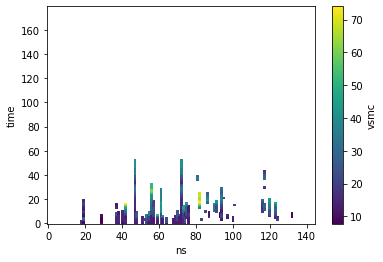

In [91]:
obs_trop_wind.where(obs_year.isin(1971),drop=True).plot()

In [60]:
for iy in np.arange(0,50):
    year_wind = obs_trop_wind.where(obs_year.isin(1971+iy),drop=True)
    for j in np.arange(0,32):
        tmp_wind = year_wind.where((year_wind.lon>=ilon[j]) & (year_wind.lon<ilon[j+1]),drop=True)
        wind3 = tmp_wind**3
        pdi_obs[iy,j] = wind3.sum()
        del tmp_wind
        del wind3
    del year_wind

In [61]:
pdi['lon'] = ilon
pdi_fma['lon'] = ilon


In [62]:
pdi_obs['lon'] = ilon

In [63]:
pdi_obs

<xarray.DataArray (year: 50, lon: 33)>
array([[6.64558291e+05, 6.01635876e+05, 2.74483563e+05, ...,
        1.06383667e+05, 1.21007805e+06, 0.00000000e+00],
       [3.80678868e+05, 3.51367616e+05, 1.21520243e+05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.51653313e+05, 2.22091860e+06, 7.52480218e+05, ...,
        0.00000000e+00, 1.31554271e+04, 0.00000000e+00],
       ...,
       [4.30572193e+03, 4.46722905e+05, 1.92086254e+06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.15415458e+06, 6.33110493e+05, 1.76093339e+05, ...,
        1.08919448e+03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * year     (year) int64 1971 1972 1973 1974 1975 ... 2016 2017 2018 2019 2020
  * lon      (lon) int64 120 125 130 135 140 145 150 ... 255 260 265 270 275 280

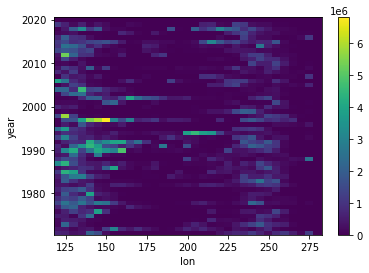

In [161]:
pdi_obs[:].plot()

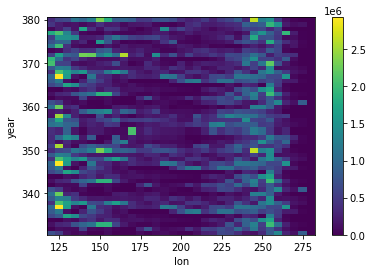

In [101]:
pdi[30:80].plot()

### 3.2 get annual PDI for entire equatorial paciifc, eastern and western equaotiral pacific

In [64]:
# annual PDI for Eastern equatorial pacific 205-275
pdi_ann_east = pdi.sel(lon=slice(205,275)).sum('lon')
pdi_fma_east = pdi_fma.sel(lon=slice(205,275)).sum('lon')
pdi_obs_east = pdi_obs.sel(lon=slice(205,275)).sum('lon')

#pdi_ann.where(pdi_ann>=0.9e7,drop=True).year

In [65]:
# annual PDI for entire equaotiral pacific, 120-275
pdi_ann_whole = pdi.sel(lon=slice(120,275)).sum('lon')
pdi_fma_whole = pdi_fma.sel(lon=slice(120,275)).sum('lon')
pdi_obs_whole = pdi_obs.sel(lon=slice(120,275)).sum('lon')


In [66]:
# annul PDI for western equatorial pacific, 120-180
pdi_ann_west = pdi.sel(lon=slice(120,202)).sum('lon')
pdi_fma_west = pdi_fma.sel(lon=slice(120,202)).sum('lon')
pdi_obs_west = pdi_obs.sel(lon=slice(120,202)).sum('lon')


### 3.3 Get nino index and PDI relationship

#### extreme elnino and lanina cases, index bigger than 1.5 standard deviation

In [60]:
ninoyear

<xarray.DataArray 'year' (time: 35)>
array([302, 303, 306, 315, 318, 322, 326, 336, 341, 356, 359, 365, 366,
       369, 375, 379, 380, 389, 392, 402, 408, 409, 413, 419, 426, 429,
       430, 433, 434, 435, 442, 447, 454, 463, 472])
Coordinates:
  * time     (time) object 0302-12-01 00:00:00 ... 0472-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

In [67]:
elnino0 = nino_ndj0.where(nino_ndj0>=1,drop=True)
elnino0

<xarray.DataArray 'TEMP' (time: 18)>
array([1.4731922, 1.22336  , 1.1993268, 1.7972324, 1.1360723, 1.1623077,
       1.1063504, 1.2151759, 1.7578586, 2.065888 , 1.3210976, 1.4787047,
       1.4968002, 1.9465722, 1.9198494, 1.8879147, 1.3950742, 2.1165888],
      dtype=float32)
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0383-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

In [68]:
elnino_obs = nino_ndj_obs.where(nino_ndj_obs>=1, drop=True)
big_elnino_obs = nino_ndj_obs.where(nino_ndj_obs>=1.5,drop=True)
big_elnino_obs


<xarray.DataArray 'nino34' (time: 6)>
array([1.59616667, 1.92283333, 2.3095    , 2.41616667, 1.6095    ,
       2.59616667])
Coordinates:
  * time     (time) datetime64[ns] 1930-12-31 1972-12-31 ... 2015-12-31
    month    (time) int64 12 12 12 12 12 12

In [69]:
elnino = nino_ndj.where(nino_ndj>=1,drop=True)
# nino3 and nino4 index for elnino years
elnino3 = nino_ndj_nino3.where(nino_ndj>=1, drop=True)
elnino4  = nino_ndj_nino4.where(nino_ndj>=1, drop=True)

big_elnino = nino_ndj.where(nino_ndj>=1.5,drop=True)
big_elnino3 = nino_ndj_nino3.where(nino_ndj>=1.5,drop=True)
big_elnino4 = nino_ndj_nino4.where(nino_ndj>=1.5,drop=True)


In [70]:
lanina = nino_ndj.where(nino_ndj<=-1,drop=True)
big_lanina = nino_ndj.where(nino_ndj<=-1.5,drop=True)

In [71]:
big_nino_year = big_elnino.time.dt.year 

In [72]:
big_nina_year = big_lanina.time.dt.year

In [73]:
big_elnino[4:15]

<xarray.DataArray 'TEMP' (time: 11)>
array([1.5442023, 1.7420633, 1.7458425, 2.2635617, 2.5910788, 1.6870097,
       3.5416   , 2.3761406, 2.4472923, 1.9196613, 2.1356695],
      dtype=float32)
Coordinates:
  * time     (time) object 0326-12-01 00:00:00 ... 0430-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 12

#### add in the OHC factor

In [100]:
#read in dz and tarea
test = xr.open_dataset("/glade/scratch/huili7/archive/test_pe/ocn/hist/test_pe.pop.h.once.nc")
dz = test.dz

dsohc = xr.open_mfdataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/monthly/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.*-05.nc')
#temp = dsohc.TEMP.sel(z_t=slice(0,30000), lat=slice(-5,5),lon=slice(120,290))
temp=dsohc.TEMP
temp_tc = temp.where((temp.TLAT>=-5)&(temp.TLAT<=5)&(temp.TLONG>=120)&(temp00.TLONG<290), drop=True)

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [95]:
dohc0 = xr.open_mfdataset('/glade/campaign/cgd/ccr/nanr/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/ocn/hist/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.03*-05.nc')
temp00 = dohc0.TEMP

In [96]:
temp0 = temp00.where((temp00.TLAT>=-5)&(temp00.TLAT<=5)&(temp00.TLONG>=120)&(temp00.TLONG<290), drop=True)

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [101]:
temp_tc

,Array,Chunk
Bytes,189.12 MiB,1.31 MiB
Shape,"(144, 60, 38, 151)","(1, 60, 38, 151)"
Count,2796 Tasks,144 Chunks
Type,float32,numpy.ndarray


In [102]:
zt_in_m = change_units(dsohc, "z_t", "z_t", "m")
dz_in_m = change_units(test,"dz","dz","m")

In [109]:
ohc_300_0 = calculate_ohc(temp0, dz_in_m, zt_in_m, 'z_t',300)
OHC_0 = ohc_300_0.sum(('nlat','nlon'))

(100, 26, 38, 151)


In [110]:
ohc_300 = calculate_ohc(temp_tc, dz_in_m, zt_in_m,'z_t',300)
OHC = ohc_300.sum(('nlat','nlon')) 

(144, 26, 38, 151)


In [111]:
OHC_0 = OHC_0.compute()
OHC = OHC.compute()

In [112]:
OHC_nino0 = OHC_0.where(OHC_0.time.dt.year.isin(elnino0.time.dt.year),drop=True)
OHC_nino = OHC.where(OHC.time.dt.year.isin(elnino[7:].time.dt.year),drop=True)

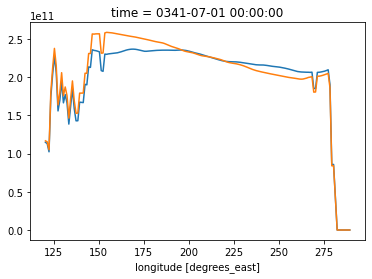

In [181]:
ohc_300[50,:,:].sum('lat').plot()
ohc_300[11,:,:].sum('lat').plot()

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


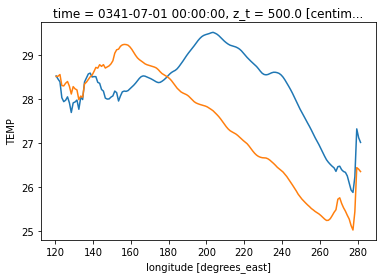

In [182]:
temp[50,0,:,:].mean('lat').plot()
temp[11,0,:,:].mean('lat').plot()

In [113]:
OHC_nino['time'] = OHC_nino.time.dt.year
OHC_nino0['time'] = OHC_nino0.time.dt.year

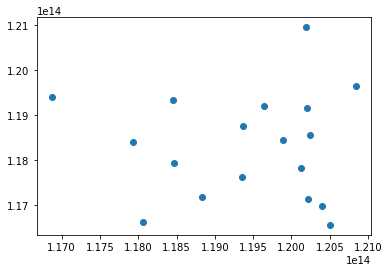

In [119]:

plt.scatter(OHC_nino[0:18], OHC_nino0)

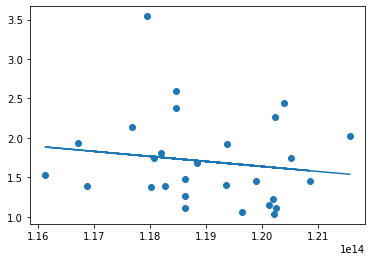

In [122]:
y = elnino[7:]
x = OHC_nino
x1 = pdi_ann_whole.sel(year=ninoyear[7:])
x2 = pdi_ann_west.sel(year=ninoyear[7:])

plt.scatter(x,y)
#plt.scatter(x1,y,color='red')
#plt.scatter(x2,y,color='green')

m, b = np.polyfit(x,y, 1)
#m1, b1 = np.polyfit(x1,y, 1)
#m2, b2 = np.polyfit(x2,y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)
#plt.plot(x1, m1*x1+b1,color='red')
#plt.plot(x2, m2*x2+b2,color='green')

In [123]:
y = elnino_obs
x = pdi_obs_whole.sel(year=elnino_obs.time.dt.year)
x1 = pdi_obs_east.sel(year=elnino_obs.time.dt.year)
x2 = pdi_obs_west.sel(year=elnino_obs.time.dt.year)

plt.scatter(x,y)
plt.scatter(x1,y,color='red')
plt.scatter(x2,y,color='green')

m, b = np.polyfit(x,y, 1)
m1, b1 = np.polyfit(x1,y, 1)
m2, b2 = np.polyfit(x2,y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)
plt.plot(x1, m1*x1+b1,color='red')
plt.plot(x2, m2*x2+b2,color='green')

KeyError: "not all values found in index 'year'"

In [153]:
OHC_big_elnino = OHC.where(OHC.time.dt.year.isin(big_elnino[5:].time.dt.year),drop=True)

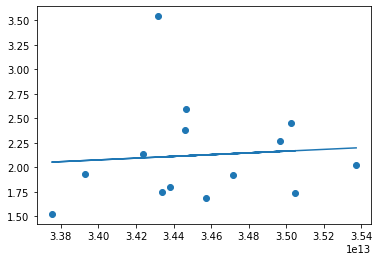

In [154]:
y = big_elnino[5:]
x = OHC_big_elnino
x1 = pdi_ann_east.sel(year=big_nino_year[5:])
x2 = pdi_ann_west.sel(year=big_nino_year[5:])

plt.scatter(x,y)
#plt.scatter(x1,y,color='red')
#plt.scatter(x2,y,color='green')

m, b = np.polyfit(x,y, 1)
#m1, b1 = np.polyfit(x1,y, 1)
#m2, b2 = np.polyfit(x2,y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)
#plt.plot(x1, m1*x1+b1,color='red')
#plt.plot(x2, m2*x2+b2,color='green')

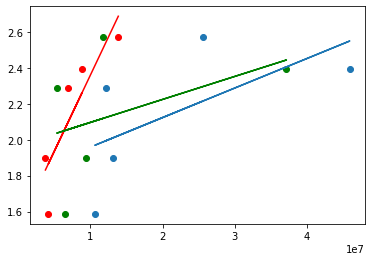

In [166]:
y = big_elnino_obs
x = pdi_obs_whole.sel(year=big_elnino_obs.time.dt.year)
x1 = pdi_obs_east.sel(year=big_elnino_obs.time.dt.year)
x2 = pdi_obs_west.sel(year=big_elnino_obs.time.dt.year)

plt.scatter(x,y)
plt.scatter(x1,y,color='red')
plt.scatter(x2,y,color='green')

m, b = np.polyfit(x,y, 1)
m1, b1 = np.polyfit(x1,y, 1)
m2, b2 = np.polyfit(x2,y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)
plt.plot(x1, m1*x1+b1,color='red')
plt.plot(x2, m2*x2+b2,color='green')

### 3.4 correlation between extreme el nino (nino index > 1.5) and TC PDI

In [100]:
import scipy.stats as stats


In [101]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    #ci = 1.96 * s_err
    ax.fill_between(x2, y2 + ci, y2 - ci, color="steelblue",alpha=0.3, edgecolor="")

    return ax
# color #b9cfe7


In [179]:
OHC['time'] = OHC.time.dt.year

In [231]:
big_elnino

<xarray.DataArray 'TEMP' (time: 19)>
array([1.5033934, 1.9688065, 2.849461 , 2.03623  , 1.5442023, 1.7420633,
       1.7458425, 2.2635617, 2.5910788, 1.6870097, 3.5416   , 2.3761406,
       2.4472923, 1.9196613, 2.1356695, 1.5237508, 1.9300461, 1.8020643,
       2.0259104], dtype=float32)
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0472-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

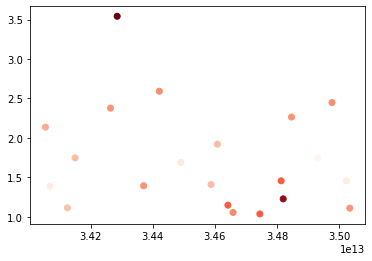

In [191]:
import matplotlib
sorted_tc = elnino[7:28].sortby(elnino[7:28]).time.dt.year   # year sorted by elnino strength
x = OHC.sel(time=sorted_tc)
y = pdi_ann_west.sel(year=sorted_tc)
z = elnino[7:28].sortby(elnino[7:28])


plt.scatter(x,z,c=y,cmap='Reds')

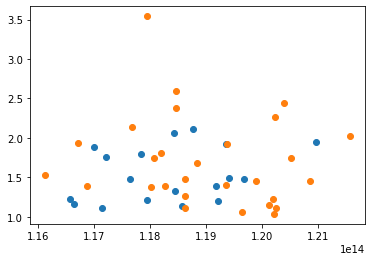

In [134]:
plt.scatter(OHC_nino0, elnino0)
plt.scatter(OHC_nino, elnino[7:])

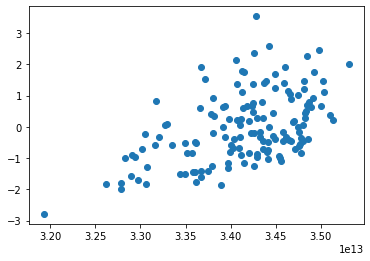

In [192]:
plt.scatter(OHC,nino_ndj[29:])
#OHC has dicernable relationship dividing elnino and lanina. but within elnino, the OHC doens't have a linear relationship.

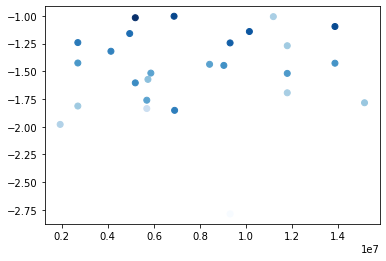

In [239]:
sorted_tc = lanina[8:].sortby(lanina[8:]).time.dt.year   # year sorted by elnino strength
x = OHC.sel(time=sorted_tc)
y = pdi_ann_west.sel(year=sorted_tc)
z = lanina[8:].sortby(lanina[8:])


plt.scatter(y,z,c=x,cmap='Blues')

In [102]:
# Computations ----------------------------------------------------------------    

sorted_tc = elnino[7:28].sortby(elnino[7:28]).time.dt.year   # year sorted by elnino strength
x = OHC_nino[7:28].sel(time=sorted_tc)
y = pdi_ann_west.sel(year=sorted_tc)

colors=  matplotlib.cm.get_cmap('Reds')


# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(
    x, y, "o", color=colors, markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
ax = plot_ci_manual(t, s_err.data, n, x.data, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err.data * np.sqrt(1 + 1/n + (x2 - np.mean(x.data))**2 / np.sum((x.data - np.mean(x.data))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")

#plt.show()

NameError: name 'OHC_nino' is not defined

In [123]:

y = big_elnino.where(big_elnino<=2.4)
y

<xarray.DataArray 'TEMP' (time: 19)>
array([1.5033934, 1.9688065,       nan, 2.03623  , 1.5442023, 1.7420633,
       1.7458425, 2.2635617,       nan, 1.6870097,       nan, 2.3761406,
             nan, 1.9196613, 2.1356695, 1.5237508, 1.9300461, 1.8020643,
       2.0259104], dtype=float32)
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0472-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

In [118]:
big_elnino[0:11]

<xarray.DataArray 'TEMP' (time: 11)>
array([1.5033934, 1.9688065, 2.849461 , 2.03623  , 1.5442023, 1.7420633,
       1.7458425, 2.2635617, 2.5910788, 1.6870097, 3.5416   ],
      dtype=float32)
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0380-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 12

In [114]:
big_elnino[5:15]

<xarray.DataArray 'TEMP' (time: 10)>
array([1.7420633, 1.7458425, 2.2635617, 2.5910788, 1.6870097, 3.5416   ,
       2.3761406, 2.4472923, 1.9196613, 2.1356695], dtype=float32)
Coordinates:
  * time     (time) object 0341-12-01 00:00:00 ... 0430-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12

1.5050341609514447e-07 1.28180931083749 0.9593543393880033 1.1368232299985937e-05 1.565257900599493e-08


In [143]:
big_elnino[0:12]

<xarray.DataArray 'TEMP' (time: 12)>
array([1.5033934, 1.9688065, 2.849461 , 2.03623  , 1.5442023, 1.7420633,
       1.7458425, 2.2635617, 2.5910788, 1.6870097, 3.5416   , 2.3761406],
      dtype=float32)
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0409-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 12 12

In [153]:
big_nino_year.where(big_nino_year!=380)[5:15]

<xarray.DataArray 'year' (time: 10)>
array([341., 366., 369., 375., 379.,  nan, 409., 413., 426., 430.])
Coordinates:
  * time     (time) object 0341-12-01 00:00:00 ... 0430-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12

In [113]:
elnino[0:20]

<xarray.DataArray 'TEMP' (time: 20)>
array([1.2359042, 1.5033934, 1.9688065, 2.849461 , 1.4415402, 2.03623  ,
       1.5442023, 1.4076284, 1.7420633, 1.0534508, 1.1465881, 1.1085124,
       1.7458425, 2.2635617, 2.5910788, 1.6870097, 3.5416   , 1.4548023,
       1.4536543, 1.38638  ], dtype=float32)
Coordinates:
  * time     (time) object 0302-12-01 00:00:00 ... 0402-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

In [142]:
big_elnino[5:]

<xarray.DataArray 'TEMP' (time: 14)>
array([1.7420633, 1.7458425, 2.2635617, 2.5910788, 1.6870097, 3.5416   ,
       2.3761406, 2.4472923, 1.9196613, 2.1356695, 1.5237508, 1.9300461,
       1.8020643, 2.0259104], dtype=float32)
Coordinates:
  * time     (time) object 0341-12-01 00:00:00 ... 0472-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 12 12 12 12

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


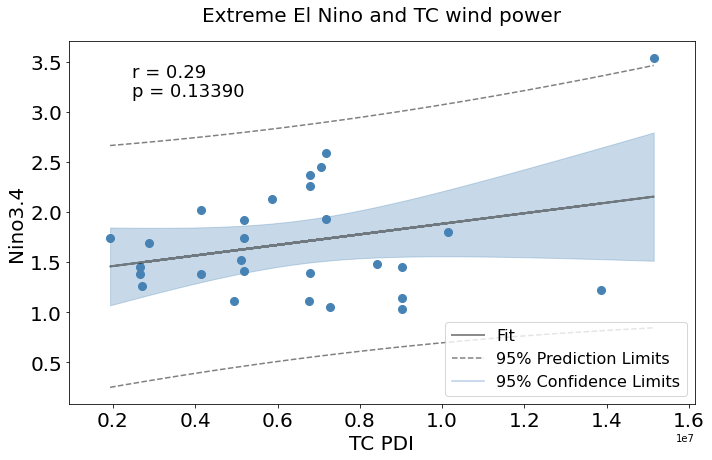

In [141]:
# Computations for including all values  ----------------------------------------------------------------    

#y = big_elnino[5:].where(big_elnino[5:]<=3, drop=True)
#x = pdi_ann_west.sel(year=big_nino_year[5:].where(big_nino_year[5:]!=380,drop=True))

#y = big_elnino[5:]
#x = pdi_ann_west.sel(year=big_nino_year[5:])

y = elnino[7:]
x = pdi_ann_west.sel(year=ninoyear[7:])

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)


# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6.5),constrained_layout=True)

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="steelblue", markerfacecolor="steelblue"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=2, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
ax = plot_ci_manual(t, s_err.data, n, x.data, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err.data * np.sqrt(1 + 1/n + (x2 - np.mean(x.data))**2 / np.sum((x.data - np.mean(x.data))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Labels
plt.xlabel("TC PDI",fontsize=20)
plt.ylabel("Nino3.4", fontsize=20)
plt.title("Extreme El Nino and TC wind power",fontsize=20,pad=20)
plt.xlim(np.min(x) - 1e6, np.max(x) + 1e6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
    loc="lower right",fontsize=16
    #loc=9, bbox_to_anchor=(0, -0.25, 1., 0.102), ncol=3, mode="expand"
)  

# wirte r value and p value
ax.text(0.1, 0.9, 'r = '+ "%.2f" % r_value, transform=ax.transAxes,fontsize=18)
ax.text(0.1, 0.85, 'p = '+ "%.5f" % p_value, transform=ax.transAxes,fontsize=18)




plt.tight_layout()
#plt.savefig("pdi_nino_scatter_longer.png", bbox_extra_artists=(legend,), bbox_inches="tight")


In [83]:
slope, intercept, r_value, p_value, std_err = stats.linregress(pdi_ann_west.sel(year=big_nino_year[5:15]), big_elnino[5:15])

print(slope,intercept, r_value, p_value, std_err )

1.5050341609514447e-07 1.28180931083749 0.9593543393880033 1.1368232299985937e-05 1.565257900599493e-08


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


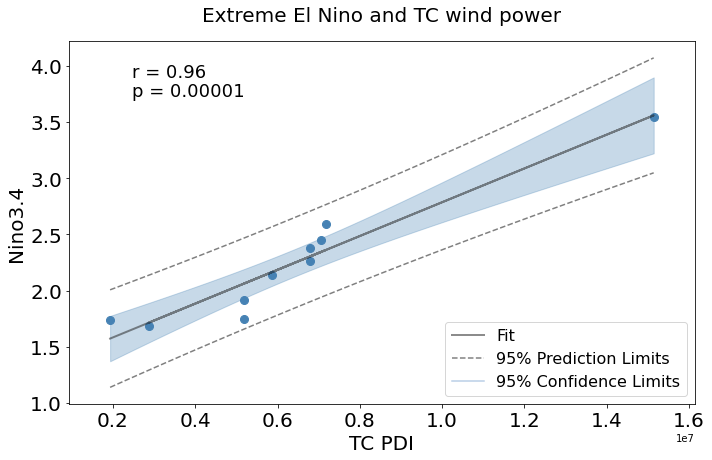

In [93]:
# Computations for including all values  ----------------------------------------------------------------    

y = big_elnino[5:15]
x = pdi_ann_west.sel(year=big_nino_year[5:15])

slope, intercept, r_value, p_value, std_err = stats.linregress(pdi_ann_west.sel(year=big_nino_year[5:15]), big_elnino[5:15])


# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6.5),constrained_layout=True)

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="steelblue", markerfacecolor="steelblue"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=2, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
ax = plot_ci_manual(t, s_err.data, n, x.data, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err.data * np.sqrt(1 + 1/n + (x2 - np.mean(x.data))**2 / np.sum((x.data - np.mean(x.data))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Labels
plt.xlabel("TC PDI",fontsize=20)
plt.ylabel("Nino3.4", fontsize=20)
plt.title("Extreme El Nino and TC wind power",fontsize=20,pad=20)
plt.xlim(np.min(x) - 1e6, np.max(x) + 1e6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
    loc="lower right",fontsize=16
    #loc=9, bbox_to_anchor=(0, -0.25, 1., 0.102), ncol=3, mode="expand"
)  

# wirte r value and p value
ax.text(0.1, 0.9, 'r = '+ "%.2f" % r_value, transform=ax.transAxes,fontsize=18)
ax.text(0.1, 0.85, 'p = '+ "%.5f" % p_value, transform=ax.transAxes,fontsize=18)




plt.tight_layout()
plt.savefig("pdi_nino_scatter.png", bbox_extra_artists=(legend,), bbox_inches="tight")


In [ ]:

print(slope,intercept, r_value, p_value, std_err )

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


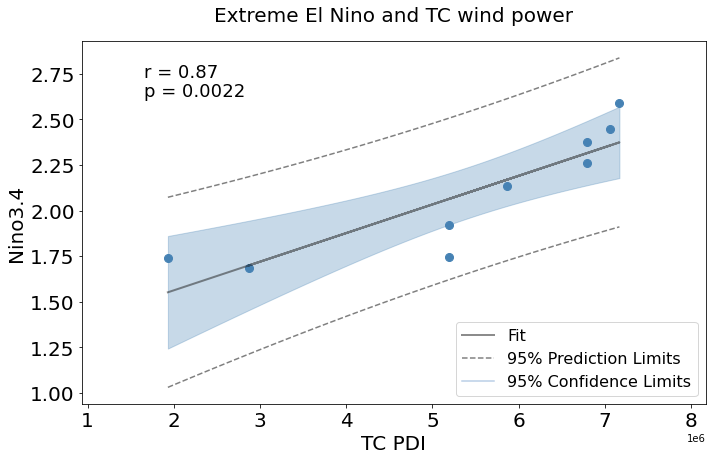

In [88]:
# Computations for neglecting the super event at year 380 ----------------------------------------------------------------    
tmp = big_elnino[5:15].copy(data=big_elnino[5:15].data)
tmp1 = tmp.where(tmp<=3,drop=True)
y = tmp1
x = pdi_ann_west.sel(year=big_nino_year.where(big_nino_year!=380,drop=True)[5:14])

slope, intercept, r_value, p_value, std_err = stats.linregress(pdi_ann_west.sel(year=big_nino_year.where(big_nino_year!=380,drop=True)[5:14]), tmp1)

# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6.5),constrained_layout=True)

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="steelblue", markerfacecolor="steelblue"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=2, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
ax = plot_ci_manual(t, s_err.data, n, x.data, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err.data * np.sqrt(1 + 1/n + (x2 - np.mean(x.data))**2 / np.sum((x.data - np.mean(x.data))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Labels
plt.xlabel("TC PDI",fontsize=20)
plt.ylabel("Nino3.4", fontsize=20)
plt.title("Extreme El Nino and TC wind power",fontsize=20,pad=20)
plt.xlim(np.min(x) - 1e6, np.max(x) + 1e6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
    loc="lower right",fontsize=16
    #loc=9, bbox_to_anchor=(0, -0.25, 1., 0.102), ncol=3, mode="expand"
)  

# wirte r value and p value
ax.text(0.1, 0.9, 'r = '+ "%.2f" % r_value, transform=ax.transAxes,fontsize=18)
ax.text(0.1, 0.85, 'p = '+ "%.4f" % p_value, transform=ax.transAxes,fontsize=18)




plt.tight_layout()
plt.savefig("pdi_nino_scatter_nomax.png", bbox_extra_artists=(legend,), bbox_inches="tight")


### correlation for observations

In [92]:
# Computations ----------------------------------------------------------------    
y = big_elnino_obs
x = pdi_obs_west.sel(year=big_elnino_obs.time.dt.year)


# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="none"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
ax = plot_ci_manual(t, s_err.data, n, x.data, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err.data * np.sqrt(1 + 1/n + (x2 - np.mean(x.data))**2 / np.sum((x.data - np.mean(x.data))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")


# Labels
plt.xlabel("TC PDI",fontsize=16)
plt.ylabel("Nino3.4", fontsize=16)
plt.xlim(np.min(x) - 1e6, np.max(x) + 1e6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Custom legend
handles, labels = ax.get_legend_handles_labels()
display = (0, 1)
anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
    [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
    loc=9, bbox_to_anchor=(0, -0.25, 1., 0.102), ncol=3, mode="expand"
)  
#frame = legend.get_frame().set_edgecolor("0.5")
#plt.show()
plt.tight_layout()
#plt.savefig("pdi_nino_scatter.png", bbox_extra_artists=(legend,), bbox_inches="tight")


KeyError: "not all values found in index 'year'"

In [509]:
pdi_ann2[30:].where(pdi_ann2[30:]>2.e7,drop=True).year

<xarray.DataArray 'year' (year: 23)>
array([337, 338, 347, 348, 350, 367, 368, 372, 380, 397, 398, 407, 408, 410,
       427, 428, 432, 440, 457, 458, 467, 468, 470])
Coordinates:
  * year     (year) int64 337 338 347 348 350 367 ... 440 457 458 467 468 470

## 4. Nino DJF SST zonal distribution

In [601]:
#emp_clm = temp.groupby(temp.time.dt.dayofyear).mean()
#temp_anom = temp.groupby(temp.time.dt.dayofyear) - temp_clm
#temp_anom.to_netcdf('/glade/campaign/cgd/ccr/huili7/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/proc/b.e13.B1850C5CN.ne30_g16.005ax_exact_tc.pop.h.temp.dayclmanom.0330-0399.nc')

In [602]:
#temp_anom

,Array,Chunk
Bytes,3.96 GiB,162.50 kiB
Shape,"(25550, 26, 10, 160)","(1, 26, 10, 160)"
Count,141695 Tasks,25550 Chunks
Type,float32,numpy.ndarray


### 4.1 Control run

In [67]:
eq_pac = TS.sel(lat=slice(-2.5, 2.5),lon=slice(120,280))
nlat = np.size(eq_pac.lat)
nlon = np.size(eq_pac.lon)
eqClm = eq_pac.groupby(eq_pac.time.dt.month).mean()
eqAnom = eq_pac.groupby(eq_pac.time.dt.month) - eqClm

In [68]:
eqAnom

<xarray.DataArray 'TEMP' (time: 1200, lat: 6, lon: 161)>
array([[[        nan,         nan,         nan, ...,  0.07843399,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  0.03437042,
                 nan,         nan],
        [ 0.8507786 ,  0.8447628 ,  0.8217888 , ..., -0.00225067,
                 nan,         nan],
        [ 0.88889885,         nan,         nan, ..., -0.06541443,
                 nan,         nan],
        [ 0.9021282 ,  1.040596  ,  1.0803051 , ..., -0.06671906,
          0.08236504,  0.14012337],
        [ 0.98742867,  1.1119328 ,  1.1267738 , ..., -0.01176643,
          0.05428314,  0.12323952]],

       [[        nan,         nan,         nan, ...,  0.13554764,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  0.12217522,
                 nan,         nan],
        [ 0.59451294,  0.623497  ,  0.59763336, ...,  0.09446716,
                 nan,         nan],
        [ 0.6483269 ,         nan,         nan, ..., -0.06408691,
...
                 nan,         nan],
        [-0.10499382,         nan,         nan, ..., -0.238348  ,
                 nan,         nan],
        [-0.0661335 , -0.11303711, -0.13244438, ..., -0.33041954,
         -0.3392563 , -0.35429   ],
        [-0.06236649, -0.09318352, -0.11682129, ..., -0.5195122 ,
         -0.49306107, -0.45394325]],

       [[        nan,         nan,         nan, ..., -0.40607452,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.3969803 ,
                 nan,         nan],
        [-0.02689362, -0.09578705, -0.11869621, ..., -0.28793907,
                 nan,         nan],
        [ 0.05841064,         nan,         nan, ..., -0.431036  ,
                 nan,         nan],
        [ 0.10225105,  0.0620575 ,  0.02360344, ..., -0.5186863 ,
         -0.5870533 , -0.6144829 ],
        [ 0.12549782,  0.10092163,  0.06017303, ..., -0.6019192 ,
         -0.5725231 , -0.52955055]]], dtype=float32)
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0401-01-01 00:00:00
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 277.0 278.0 279.0 280.0
  * lat      (lat) float64 -2.5 -1.5 -0.5 0.5 1.5 2.5
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

In [69]:
eqDJF_anom = eqAnom[1:].sel(time=eqAnom[1:]['time.season']=='DJF')

eqDJF_anom = eqDJF_anom.rolling(time=3, center=True).mean()

eqDJF_anom_avg = eqDJF_anom[1:299:3]

eqDJF_anom_avg

<xarray.DataArray 'TEMP' (time: 100, lat: 6, lon: 161)>
array([[[        nan,         nan,         nan, ..., -0.66388446,
                 nan,         nan],
        [        nan,         nan,         nan, ..., -0.63884544,
                 nan,         nan],
        [-0.14997737, -0.14329338, -0.12561862, ..., -0.5719897 ,
                 nan,         nan],
        [-0.13518079,         nan,         nan, ..., -0.5543086 ,
                 nan,         nan],
        [-0.11679268, -0.12700462, -0.11927477, ..., -0.567599  ,
         -0.5073783 , -0.45358148],
        [-0.08725039, -0.11894226, -0.13020325, ..., -0.544693  ,
         -0.59253377, -0.5118243 ]],

       [[        nan,         nan,         nan, ...,  0.3334732 ,
                 nan,         nan],
        [        nan,         nan,         nan, ...,  0.3492616 ,
                 nan,         nan],
        [-0.11255201, -0.11701775, -0.10690435, ...,  0.30669403,
                 nan,         nan],
        [-0.11492475,         nan,         nan, ...,  0.27276993,
...
                 nan,         nan],
        [ 0.00119209,         nan,         nan, ..., -0.00684357,
                 nan,         nan],
        [ 0.04838371,  0.05148761,  0.04273733, ...,  0.08114942,
          0.06558228,  0.07200559],
        [ 0.08307838,  0.09381104,  0.07096736, ...,  0.08427366,
          0.05466207,  0.05611293]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * time     (time) object 0302-01-01 00:00:00 ... 0401-01-01 00:00:00
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 277.0 278.0 279.0 280.0
  * lat      (lat) float64 -2.5 -1.5 -0.5 0.5 1.5 2.5
    z_t      float32 500.0
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1

In [30]:
ninoyear0

<xarray.DataArray 'year' (time: 18)>
array([303, 304, 309, 310, 313, 314, 322, 328, 339, 342, 346, 349, 363,
       366, 368, 372, 377, 383])
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0383-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12

In [70]:
eqDJF_anom_nino = eqDJF_anom_avg.isel(time=eqDJF_anom_avg.time.dt.year.isin(ninoyear0+1))

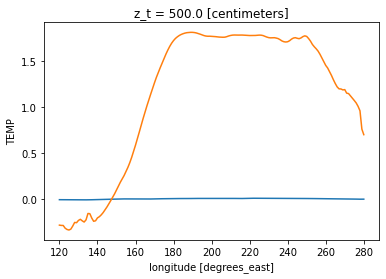

In [71]:
eqDJF_anom_avg.mean(('time','lat')).plot()
eqDJF_anom_nino.mean(('time','lat')).plot()

### 4.2 TC run

In [33]:

eq_pac_tc = TS_TC.sel(lat=slice(-2.5, 2.5),lon=slice(120,280))
nlat = np.size(eq_pac_tc.lat)
nlon = np.size(eq_pac_tc.lon)

eqClm_tc  = eq_pac_tc.groupby(eq_pac_tc.time.dt.month).mean()
eqAnom_tc = eq_pac_tc.groupby(eq_pac_tc.time.dt.month) -  eqClm_tc




In [34]:
# detrend
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

eqAnom_tc = detrend_dim(eqAnom_tc,'time',1)


In [35]:
eqDJF_anom_tc = eqAnom_tc[1:].sel(time=eqAnom_tc[1:]['time.season']=='DJF')

In [36]:
eqDJF_anom_tc = eqDJF_anom_tc.rolling(time=3, center=True).mean()

In [37]:
eqDJF_anom_tc

<xarray.DataArray (time: 518, lat: 6, lon: 161)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
         -4.13094043e-01,             nan,             nan],
        [            nan,             nan,             nan, ...,
         -3.75087688e-01,             nan,             nan],
        [-2.57826997e-01, -2.22452866e-01, -1.64995712e-01, ...,
         -3.18670493e-01,             nan,             nan],
        [-1.96243153e-01,             nan,             nan, ...,
...
          1.11355988e+00,             nan,             nan],
        [ 1.89829040e-01,             nan,             nan, ...,
          9.39054868e-01,             nan,             nan],
        [ 1.77906052e-01,  1.75370363e-01,  1.92931411e-01, ...,
          8.89594154e-01,  8.10912335e-01,  7.22184519e-01],
        [ 1.77580744e-01,  1.82433337e-01,  1.97692868e-01, ...,
          9.93510653e-01,  9.23258743e-01,  7.70919544e-01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * time     (time) object 0301-12-01 00:00:00 ... 0474-01-01 00:00:00
  * lon      (lon) float64 120.0 121.0 122.0 123.0 ... 277.0 278.0 279.0 280.0
  * lat      (lat) float64 -2.5 -1.5 -0.5 0.5 1.5 2.5
    z_t      float32 500.0
    month    (time) int64 12 1 2 12 1 2 12 1 2 12 1 ... 1 2 12 1 2 12 1 2 12 1

In [38]:
eqDJF_anom_avg2 = eqDJF_anom_tc[1:518:3]

In [39]:
eqDJF_anom_nino_tc = eqDJF_anom_avg2.isel(time=eqDJF_anom_avg2.time.dt.year.isin(ninoyear+1))

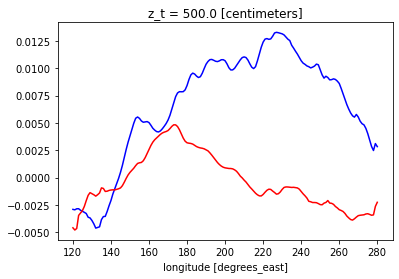

In [40]:
eqDJF_anom_avg.mean(('time','lat')).plot(color='blue')
eqDJF_anom_avg2.mean(('time','lat')).plot(color='red')

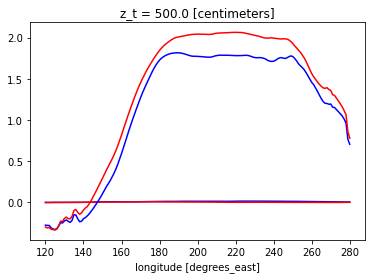

In [41]:
eqDJF_anom_avg.mean(('time','lat')).plot(color='blue')
eqDJF_anom_avg2.mean(('time','lat')).plot(color='red')
eqDJF_anom_nino[0:100].mean(('time','lat')).plot(color='blue')
eqDJF_anom_nino_tc[:].mean(('time','lat')).plot(color='red')

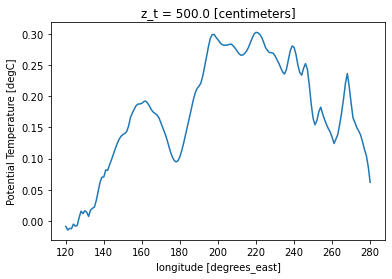

In [289]:
(eqDJF_anom_nino_tc[7:28].mean(('time','lat')) - eqDJF_anom_nino.mean(('time','lat'))).plot()

In [286]:
ninoyear[7:28]

<xarray.DataArray 'year' (time: 21)>
array([336, 341, 356, 359, 365, 366, 369, 375, 379, 380, 389, 392, 402,
       408, 409, 413, 419, 426, 429, 430, 433])
Coordinates:
  * time     (time) object 0336-12-01 00:00:00 ... 0433-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

In [309]:
ninoyear0.size

18

In [45]:
import matplotlib
cmap_blue = matplotlib.cm.get_cmap('Blues')
cmap_red = matplotlib.cm.get_cmap('Reds')
#print(rgba) # (0.99807766255210428, 0.99923106502084169, 0.74602077638401709, 1.0)

In [336]:
elnino0.sortby(elnino0)[0]['time']

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(322, 12, 1, 0, 0, 0, 0), dtype=object)
Coordinates:
    time     object 0322-12-01 00:00:00
    z_t      float32 500.0
    month    int64 12
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [343]:
eqDJF_anom_nino.time.dt.year.isin(elnino0.sortby(elnino0).time[0].dt.year+1)

<xarray.DataArray 'year' (time: 18)>
array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False])
Coordinates:
  * time     (time) object 0304-01-01 00:00:00 ... 0384-01-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

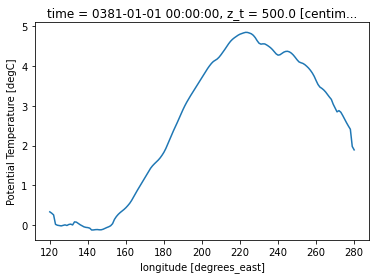

In [354]:
eqDJF_anom_nino_tc.isel(time=eqDJF_anom_nino_tc.time.dt.year.isin(sorted_tc[i])).mean('lat').plot()

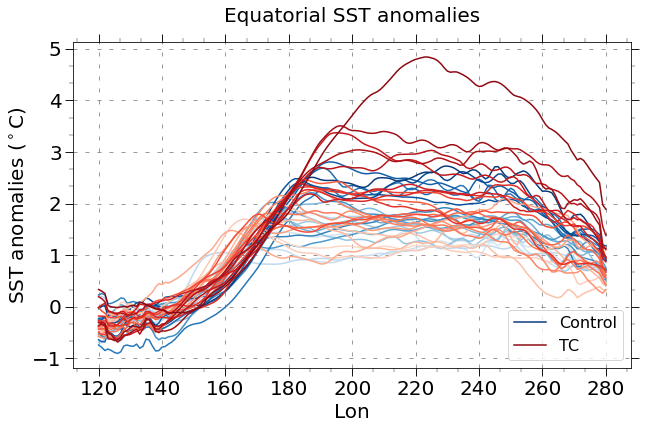

In [262]:
fig,ax=plt.subplots(figsize=(10,6))

sorted0 = elnino0.sortby(elnino0).time.dt.year + 1
sorted_tc = elnino.sortby(elnino[7:28]).time.dt.year+1

for i in np.arange(0,ninoyear0.size):
    ax.plot(eqDJF_anom_nino.lon, eqDJF_anom_nino.isel(time=eqDJF_anom_nino.time.dt.year.isin(sorted0[i])).mean(('lat','time')),color=cmap_blue((i+4)/(ninoyear0.size+4)),label="Control")
for i in np.arange(0,21):   # 330-43
    ax.plot(eqDJF_anom_nino.lon, eqDJF_anom_nino_tc.isel(time=eqDJF_anom_nino_tc.time.dt.year.isin(sorted_tc[i])).mean(('lat','time')),color=cmap_red((i+4)/26),label="TC")

gvutil.add_major_minor_ticks(ax, labelsize=20)

ax.set_xlabel('Lon',fontsize=20)
ax.set_ylabel('SST anomalies ($^\circ$C)',fontsize=20)
ax.set_title('Equatorial SST anomalies',fontsize=20,pad=20)

handles, labels = ax.get_legend_handles_labels()

display= (17,38)
legend = plt.legend(
    [handle for i, handle in enumerate(handles) if i in display],
    [label for i, label in enumerate(labels) if i in display],fontsize=16,loc='lower right') 
ax.grid(True,color="grey",linestyle=(0,(5,10)))
plt.savefig("eq_SST_anom_compare.png")



In [396]:
labels[39]

IndexError: list index out of range

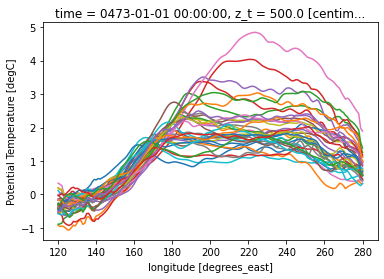

In [351]:
for i in np.arange(0,ninoyear.size):
    eqDJF_anom_nino_tc[i].mean('lat').plot()

## 5. warm pool edge comparison

In [72]:
# get TS from the atmosphere output, the real sst?
dsts = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.cam.h0.TS.030001-040012.nc')
eq_pac_sst = dsts.TS.sel(lat=slice(-2.5,2.5),lon=slice(120,280))

In [73]:
eq_pac_sst  = eq_pac_sst - 273.15

In [74]:
season = np.full(eq_pac_sst.shape,"   ")
season[np.isin(eq_pac_sst.time.dt.month,[11,12,1])] = "NDJ"
season[np.isin(eq_pac_sst.time.dt.month,[2,3,4])] = "FMA"
season[np.isin(eq_pac_sst.time.dt.month,[5,6,7])] = "MJJ"
season[np.isin(eq_pac_sst.time.dt.month,[8,9,10])] = "ASO"

In [75]:
season = eq_pac_sst.copy(data=season)

In [76]:
eq_pac_sst['season'] = season

### - get MJJ equatorial pacific SST from control

In [77]:
eq_pac_mjj = eq_pac_sst.isel(time=eq_pac_sst.time.dt.month.isin([5,6,7])).rolling(time=3, center=True).mean()
eq_pac_mjj = eq_pac_mjj[1:300:3]

In [78]:
eq_pac_mjj_nino = eq_pac_mjj.isel(time=eq_pac_mjj.time.dt.year.isin(ninoyear0))

eq_pac_mjj_nino#.where(eq_pac_mjj_nino>=29, drop=True)

<xarray.DataArray 'TS' (time: 18, lat: 6, lon: 129)>
array([[[21.517345, 23.199413, 27.037262, ..., 24.748821, 25.330292,
         22.804638],
        [24.440695, 25.472137, 26.974182, ..., 25.076305, 25.50994 ,
         22.344116],
        [28.563314, 27.541168, 27.274588, ..., 25.479675, 25.72403 ,
         23.53822 ],
        [28.474285, 27.38681 , 27.000296, ..., 25.93687 , 26.032248,
         25.668814],
        [28.579763, 28.19563 , 27.852814, ..., 26.447552, 26.368927,
         25.928976],
        [28.650787, 28.69682 , 28.770336, ..., 26.999166, 26.745779,
         26.653015]],

       [[21.761395, 23.238323, 26.921743, ..., 24.776815, 25.190777,
         22.90801 ],
        [24.5288  , 25.408722, 26.857666, ..., 25.083527, 25.429077,
         22.425762],
        [28.411407, 27.388592, 27.127758, ..., 25.463116, 25.705608,
         23.674328],
        [28.34834 , 27.270437, 26.861736, ..., 25.939047, 26.05946 ,
...
         23.186392],
        [28.057537, 27.033611, 26.664358, ..., 25.628347, 25.635406,
         25.290112],
        [28.160076, 27.816101, 27.477499, ..., 25.915771, 25.81717 ,
         25.356873],
        [28.201916, 28.276632, 28.330221, ..., 26.275045, 26.125204,
         26.049215]],

       [[21.776327, 23.278301, 26.976135, ..., 25.759085, 26.12724 ,
         23.05364 ],
        [24.523489, 25.446808, 26.9026  , ..., 25.982616, 26.232779,
         22.500652],
        [28.273174, 27.282675, 27.092773, ..., 26.204834, 26.327618,
         23.67923 ],
        [27.922466, 26.987997, 26.70868 , ..., 26.400024, 26.405233,
         25.845917],
        [28.036419, 27.668915, 27.3721  , ..., 26.699554, 26.575226,
         26.020355],
        [28.128775, 28.168325, 28.219707, ..., 27.080627, 26.852673,
         26.741241]]], dtype=float32)
Coordinates:
  * time     (time) object 0303-06-01 00:00:00 ... 0383-06-01 00:00:00
  * lat      (lat) float64 -2.356 -1.414 -0.4712 0.4712 1.414 2.356
  * lon      (lon) float64 120.0 121.2 122.5 123.8 ... 276.2 277.5 278.8 280.0
    season   (time, lat, lon) <U3 'MJJ' 'MJJ' 'MJJ' 'MJJ' ... 'MJJ' 'MJJ' 'MJJ'

### - get warm pool edge during nino year in control

In [79]:
ran = np.zeros(eq_pac_mjj_nino[:,0,0].size) 
edge = xr.DataArray(ran,dims = ['time'], coords = {"time":eq_pac_mjj_nino['time']})

for it in np.arange(0,eq_pac_mjj_nino.time.size,1):
    edge[it] = eq_pac_mjj_nino[it,:,:].where(eq_pac_mjj_nino[it,:,:]>=28.5,drop=True).lon.max()
# go over each time, find the maximum longitude of the non-missing value

In [80]:
eq_pac_mjj[41].where(eq_pac_mjj[41]>=28.5, drop=True).size

0

### - get earm pool edge for all years in control

In [81]:
ran = np.zeros(eq_pac_mjj[:,0,0].size) 
edge_all = xr.DataArray(ran,dims = ['time'], coords = {"time":eq_pac_mjj['time']})

for it in np.arange(0,eq_pac_mjj.time.size,1):
    if eq_pac_mjj[it,:,:].where(eq_pac_mjj[it,:,:]>=28.5,drop=True).size > 0:
        edge_all[it] = eq_pac_mjj[it,:,:].where(eq_pac_mjj[it,:,:]>=28.5,drop=True).lon.max()
# go over each time, find the maximum longitude of the non-missing value

In [82]:
edge_all = edge_all.where(edge_all!=0)

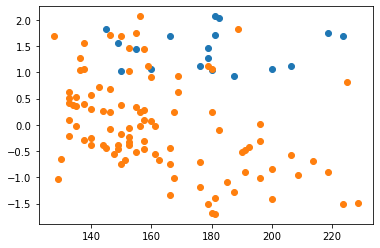

In [83]:
plt.scatter(edge,nino_ndj0_nino3.isel(time=nino_ndj0.time.dt.year.isin(ninoyear0)))
plt.scatter(edge_all,nino_ndj0_nino3)


### 5.2 get MJJ warm pool edge for TC run

In [84]:
# for TC run
dsts2 = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.TS.030101-047312.nc')
eq_pac_sst_tc = dsts2.TS.sel(lat=slice(-2.5,2.5),lon=slice(120,280))

In [85]:
eq_pac_tc_mjj = eq_pac_sst_tc.isel(time=eq_pac_sst_tc.time.dt.month.isin([5,6,7])).rolling(time=3, center=True).mean()
eq_pac_tc_mjj

<xarray.DataArray 'TS' (time: 519, lat: 6, lon: 129)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[294.6326 , 296.39737, 300.45276, ..., 297.40054, 297.60178,
         295.29016],
        [297.68478, 298.76196, 300.4126 , ..., 297.62875, 297.7842 ,
         294.73227],
        [302.00116, 300.95273, 300.74646, ..., 297.9424 , 298.01297,
         295.92154],
        [301.84778, 300.7255 , 300.3577 , ..., 298.4019 , 298.4065 ,
...
         297.6397 ],
        [301.04523, 300.1696 , 299.8477 , ..., 300.49435, 300.44495,
         299.76486],
        [301.14777, 300.7931 , 300.48645, ..., 300.84543, 300.66653,
         300.01123],
        [301.25464, 301.23322, 301.25592, ..., 301.24728, 300.98993,
         300.81726]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time     (time) object 0301-05-01 00:00:00 ... 0473-07-01 00:00:00
  * lat      (lat) float64 -2.356 -1.414 -0.4712 0.4712 1.414 2.356
  * lon      (lon) float64 120.0 121.2 122.5 123.8 ... 276.2 277.5 278.8 280.0
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean
    remap:         remapped via ESMF_regrid_with_weights: Bilinear

In [86]:
eq_pac_tc_mjj = eq_pac_tc_mjj[1:519:3]
eq_pac_tc_mjj_nino = eq_pac_tc_mjj.isel(time=eq_pac_tc_mjj.time.dt.year.isin(ninoyear))

In [183]:
eq_pac_tc_mjj_nino[9:]

<xarray.DataArray 'TS' (time: 26, lat: 6, lon: 129)>
array([[[294.84772, 296.4099 , 300.09875, ..., 298.86996, 299.005  ,
         296.0393 ],
        [297.6978 , 298.6149 , 300.01764, ..., 299.07806, 299.15866,
         295.45584],
        [301.70605, 300.58698, 300.25568, ..., 299.2785 , 299.27463,
         296.48615],
        [301.50656, 300.39377, 299.97717, ..., 299.51508, 299.40204,
         298.5993 ],
        [301.62573, 301.1408 , 300.70895, ..., 299.87927, 299.67468,
         298.91745],
        [301.65244, 301.5966 , 301.54028, ..., 300.29782, 300.02927,
         299.72833]],

       [[294.71832, 296.21457, 299.89365, ..., 298.37436, 298.4499 ,
         295.50363],
        [297.6225 , 298.49603, 299.87082, ..., 298.62976, 298.64255,
         294.92078],
        [301.59167, 300.49203, 300.16904, ..., 298.87137, 298.81073,
         296.18137],
        [301.22696, 300.19568, 299.81894, ..., 299.09753, 298.98178,
...
         296.4527 ],
        [301.23297, 300.18976, 299.79718, ..., 298.434  , 298.60168,
         298.65082],
        [301.37854, 300.96237, 300.5696 , ..., 298.9655 , 299.0033 ,
         298.6582 ],
        [301.4688 , 301.46396, 301.44418, ..., 299.55878, 299.42978,
         299.3921 ]],

       [[294.67535, 296.16376, 299.94916, ..., 297.80466, 298.31494,
         295.4889 ],
        [297.49512, 298.38763, 299.89178, ..., 298.07993, 298.47568,
         295.1088 ],
        [301.31686, 300.31543, 300.16373, ..., 298.41193, 298.6762 ,
         296.71262],
        [300.859  , 299.98718, 299.77536, ..., 298.86206, 298.97852,
         298.9964 ],
        [300.96887, 300.6706 , 300.44357, ..., 299.35324, 299.2979 ,
         298.8287 ],
        [301.06537, 301.14264, 301.24664, ..., 299.86603, 299.64612,
         299.51245]]], dtype=float32)
Coordinates:
  * time     (time) object 0356-06-01 00:00:00 ... 0472-06-01 00:00:00
  * lat      (lat) float64 -2.356 -1.414 -0.4712 0.4712 1.414 2.356
  * lon      (lon) float64 120.0 121.2 122.5 123.8 ... 276.2 277.5 278.8 280.0
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean
    remap:         remapped via ESMF_regrid_with_weights: Bilinear

In [87]:
eq_pac_tc_mjj = eq_pac_tc_mjj - 273.15

In [88]:
eq_pac_tc_mjj_nino = eq_pac_tc_mjj_nino - 273.15

In [89]:
ran = np.zeros(eq_pac_tc_mjj_nino[:,0,0].size) 
edge_tc = xr.DataArray(ran,dims = ['time'], coords = {"time":eq_pac_tc_mjj_nino['time']})

for it in np.arange(0,eq_pac_tc_mjj_nino.time.size,1):
    edge_tc[it] = eq_pac_tc_mjj_nino[it,:,:].where(eq_pac_tc_mjj_nino[it,:,:]>=28.5,drop=True).lon.max()
# go over each time, find the maximum longitude of the non-missing value

In [90]:
ran = np.zeros(eq_pac_tc_mjj[:,0,0].size) 
edge_all_tc = xr.DataArray(ran,dims = ['time'], coords = {"time":eq_pac_tc_mjj['time']})

for it in np.arange(0,eq_pac_tc_mjj.time.size,1):
    if eq_pac_tc_mjj[it,:,:].where(eq_pac_tc_mjj[it,:,:]>=28.5,drop=True).size > 0:
        edge_all_tc[it] = eq_pac_tc_mjj[it,:,:].where(eq_pac_tc_mjj[it,:,:]>=28.5,drop=True).lon.max()
# go over each time, find the maximum longitude of the non-missing value

In [91]:
edge_all_tc = edge_all_tc.where(edge_all_tc!=0)

In [92]:
edge_all[edge_all.notnull()]

<xarray.DataArray (time: 97)>
array([191.25, 133.75, 152.5 , 178.75, 206.25, 196.25, 147.5 , 132.5 ,
       152.5 , 150.  , 223.75, 161.25, 136.25, 180.  , 200.  , 176.25,
       132.5 , 166.25, 156.25, 140.  , 168.75, 187.5 , 130.  , 137.5 ,
       152.5 , 196.25, 137.5 , 160.  , 228.75, 166.25, 140.  , 157.5 ,
       180.  , 146.25, 180.  , 128.75, 132.5 , 146.25, 181.25, 135.  ,
       182.5 , 225.  , 132.5 , 158.75, 176.25, 200.  , 137.5 , 148.75,
       190.  , 140.  , 150.  , 152.5 , 167.5 , 146.25, 146.25, 155.  ,
       167.5 , 160.  , 162.5 , 140.  , 136.25, 178.75, 127.5 , 166.25,
       188.75, 145.  , 208.75, 135.  , 155.  , 218.75, 192.5 , 137.5 ,
       148.75, 157.5 , 155.  , 213.75, 152.5 , 152.5 , 143.75, 156.25,
       181.25, 196.25, 132.5 , 156.25, 161.25, 151.25, 150.  , 135.  ,
       143.75, 168.75, 157.5 , 191.25, 157.5 , 150.  , 142.5 , 157.5 ,
       185.  ])
Coordinates:
  * time     (time) object 0300-06-01 00:00:00 ... 0399-06-01 00:00:00

In [190]:
edge_all_tc[30:130][edge_all_tc[30:130].notnull()]

<xarray.DataArray (time: 98)>
array([151.25, 163.75, 161.25, 151.25, 138.75, 178.75, 172.5 , 152.5 ,
       156.25, 163.75, 208.75, 143.75, 138.75, 160.  , 166.25, 185.  ,
       158.75, 127.5 , 150.  , 176.25, 175.  , 177.5 , 142.5 , 137.5 ,
       171.25, 180.  , 132.5 , 163.75, 232.5 , 131.25, 132.5 , 166.25,
       145.  , 160.  , 203.75, 181.25, 141.25, 170.  , 227.5 , 138.75,
       150.  , 147.5 , 195.  , 223.75, 132.5 , 137.5 , 226.25, 222.5 ,
       120.  , 132.5 , 126.25, 173.75, 168.75, 161.25, 165.  , 171.25,
       172.5 , 201.25, 137.5 , 172.5 , 200.  , 160.  , 142.5 , 171.25,
       181.25, 132.5 , 141.25, 153.75, 150.  , 192.5 , 217.5 , 147.5 ,
       151.25, 176.25, 171.25, 140.  , 235.  , 217.5 , 132.5 , 138.75,
       162.5 , 233.75, 146.25, 137.5 , 152.5 , 146.25, 165.  , 210.  ,
       158.75, 166.25, 203.75, 157.5 , 150.  , 171.25, 192.5 , 132.5 ,
       166.25, 237.5 ])
Coordinates:
  * time     (time) object 0331-06-01 00:00:00 ... 0430-06-01 00:00:00

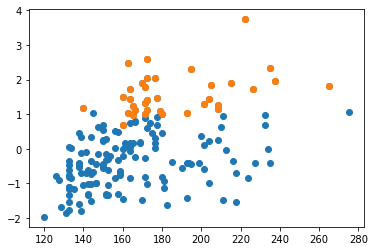

In [93]:
plt.scatter(edge_all_tc,nino_ndj_nino3)
plt.scatter(edge_tc,nino_ndj_nino3.isel(time=nino_ndj.time.dt.year.isin(ninoyear)))


### - edge vs. NDJ nino3.4 in control and TC during elnino

#### warm pool edge vs. nino3.4 in control (blue) and TC run (red), highlighting big elnino in TC run (orange)

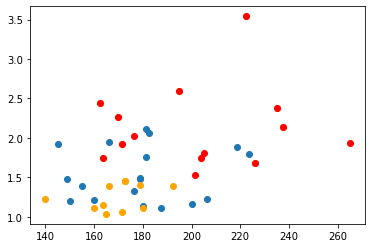

In [98]:
plt.scatter(edge,nino_ndj0.isel(time=nino_ndj0.time.dt.year.isin(ninoyear0)))
plt.scatter(edge_tc[7:28],nino_ndj.isel(time=nino_ndj.time.dt.year.isin(ninoyear[7:28])), color="orange")
plt.scatter(edge_tc[7:].isel(time=edge_tc[7:].time.dt.year.isin(big_nino_year)),big_elnino.isel(time=big_elnino.time.dt.year.isin(big_nino_year[5:])),color='red')

In [125]:
edge_tc['time'] = edge_tc.time.dt.year

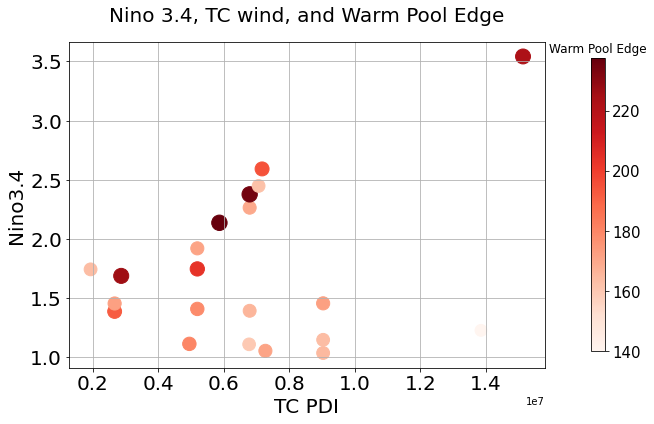

In [278]:
fig, ax = plt.subplots(figsize=(11, 6
                               ))

sorted_tc = elnino[7:28].sortby(elnino[7:28]).time.dt.year   # year sorted by elnino strength
x = edge_tc.sel(time=sorted_tc)
x2 = OHC.sel(time=sorted_tc)
y = pdi_ann_west.sel(year=sorted_tc)
z = elnino[7:28].sortby(elnino[7:28])


sc = ax.scatter(y, z, c=x, cmap="Reds",s=x)
ax.grid(True)
plt.xlabel("TC PDI",fontsize=20)
plt.ylabel("Nino3.4", fontsize=20)
plt.title("Nino 3.4, TC wind, and Warm Pool Edge",fontsize=20,pad=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


clb =plt.colorbar(sc,
             ax=ax,
             orientation='vertical',
             pad=0.075,
             shrink=0.9,
                 )
clb.ax.set_title('Warm Pool Edge',fontsize=12)

clb.ax.tick_params(labelsize=15) 
#cbar.set_label("Warm Pool Edge",fontsize=20)
#plt.scatter(y,z,c=x,cmap='Reds')
plt.savefig('scatter_wpe_pdi_nino.png')


### FMA JPDI west vs. MJJ warm pool edge during el nino

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


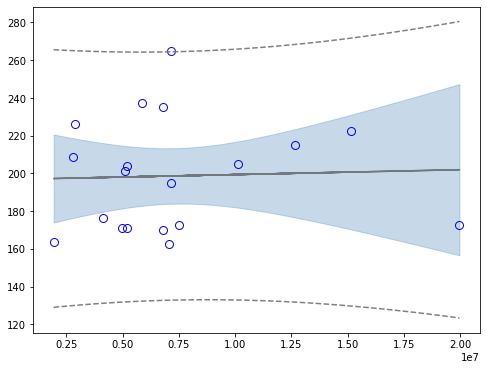

In [105]:
# TC pdi vs. warm pool edge
y = edge_tc.isel(time=edge_tc.time.dt.year.isin(big_nino_year))
x = pdi_ann_west.sel(year=big_nino_year
                    )


# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = y.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
y2 = equation(p, x2)

# Confidence Interval (select one)
ax = plot_ci_manual(t, s_err.data, n, x.data, x2, y2, ax=ax)
   
# Prediction Interval
pi = t * s_err.data * np.sqrt(1 + 1/n + (x2 - np.mean(x.data))**2 / np.sum((x.data - np.mean(x.data))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")

#plt.show()

In [445]:
edge_tc.isel(time=edge_tc.time.dt.year.isin(big_nino_year))

<xarray.DataArray (time: 19)>
array([208.75, 172.5 , 172.5 , 215.  , 171.25, 163.75, 203.75, 170.  ,
       195.  , 226.25, 222.5 , 235.  , 162.5 , 171.25, 237.5 , 201.25,
       265.  , 205.  , 176.25])
Coordinates:
  * time     (time) object 0303-06-01 00:00:00 ... 0472-06-01 00:00:00

In [446]:
big_nino_year

<xarray.DataArray 'year' (time: 19)>
array([303, 306, 315, 322, 326, 341, 366, 369, 375, 379, 380, 409, 413,
       426, 430, 434, 435, 447, 472])
Coordinates:
  * time     (time) object 0303-12-01 00:00:00 ... 0472-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 12 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12 12

### - MJJ warm pool edge for all years vs. OND nino3 for all years

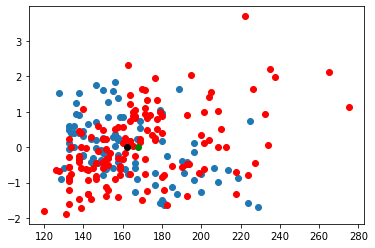

In [519]:
plt.scatter(edge_all,nino_ond0_nino3)
plt.scatter(edge_all_tc[30:],nino_ond_nino3[30:], color="red")
plt.scatter(edge_all.mean(), nino_ond0_nino3.mean(),color='black')
plt.scatter(edge_all_tc[30:].mean(), nino_ond_nino3[30:].mean(),color='green')

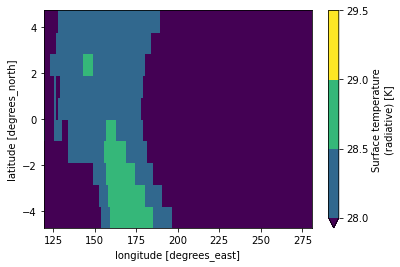

In [304]:
eq_pac_sst.isel(time=eq_pac_sst.time.dt.year.isin(ninoyear0)).mean('time').plot(levels=np.arange(28, 30, 0.5))

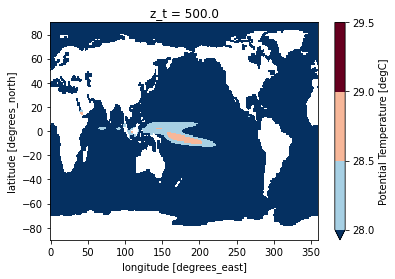

In [305]:
TS.isel(time=TS.time.dt.year.isin(ninoyear0)).mean('time').plot(levels=np.arange(28, 30, 0.5))

In [150]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit([[x, x2, y]],
        [z])

ValueError: Found array with dim 3. Estimator expected <= 2.

## 6. WWB, using taux, because TC winds are not registered in UBOT

In [73]:
#du = xr.open_mfdataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/atm/hist/6hourly/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h2.*nc')
#ubot = du.UBOT
#ubot_eq = ubot.sel(lat=slice(-5, 5), lon=slice(120, 240)).resample(time='1D').mean() * 0.8

In [75]:
#du0 = xr.open_mfdataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact.cam.h2.*.nc')
#ubot0 = du0.UBOT
#ubot0_eq = ubot0.sel(lat=slice(-5, 5), lon=slice(120, 240)).resample(time='1D').mean()* 0.8 


In [192]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask 

In [205]:
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='13GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project='P93300313', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status'})

# Setup your client
client = Client(cluster)


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39086 instead
  expected, actual


In [216]:
du = xr.open_mfdataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/daily/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.nday1.taux.0330-0399.nc',chunks={'time':360})
taux = du.TAUX_2
taux

<xarray.DataArray 'TAUX_2' (time: 25550, nlat: 384, nlon: 320)>
dask.array<open_dataset-82b72fb41426375dc8218655520ee036TAUX_2, shape=(25550, 384, 320), dtype=float32, chunksize=(360, 384, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0330-01-02 00:00:00 ... 0400-01-01 00:00:00
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Windstress in grid-x direction
    units:         dyne/centimeter^2
    grid_loc:      2220
    cell_methods:  time: mean

In [217]:
taux = taux * 0.1  # dync/cm2 to N/m2

In [286]:
threshold = 1.2 * 0.001 * 25 # rho * Cd * u_square

In [284]:
taux_eq = taux.where((taux.ULAT>=-5)&(taux.ULAT<=5)&(taux.ULONG>120)&(taux.ULONG<200),drop=True).mean('nlat')

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [ ]:
#du0 = xr.open_mfdataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact/b.e13.B1850C5CN.ne30_g16.005ax_exact.pop.h.nday1.taux.0301-0320.nc')
#taux0 = du0.TAUX_2
#taux0 = taux0 * 0.1

In [ ]:
#taux0_eq = taux0.where((taux0.ULAT>=-5)&(taux0.ULAT<=5)&(taux0.ULONG>120)&(taux0.ULONG<240),drop=True)

In [103]:
# ifnd out how many of the WWBs are associated with TCs. 
# TCs within 15-15 latitudinal band.  for each TC, check if (time,lon)

In [285]:
taux_elnino = taux_eq.isel(time=taux_eq.time.dt.year.isin(elnino.time.dt.year))

In [287]:
wwb_elnino= taux_elnino.where(taux_elnino>=threshold,drop=True)

In [288]:
yyyymmdd = 10000 * wwb_elnino.time.dt.year + 100* wwb_elnino.time.dt.month + wwb_elnino.time.dt.day
wwb_elnino.coords['yyyymmdd']= yyyymmdd

### now get the number of WWBs that are associated with TCs during El Nino years

In [223]:
yyyymmdd = 10000 * traj_trop_wind.year + 100* traj_trop_wind.month + traj_trop_wind.day
traj_trop_wind.coords['yyyymmdd'] = yyyymmdd

In [224]:
traj_wind_elnino = traj_trop_wind.where(traj_trop_wind.year.isin(elnino[7:18].time.dt.year),drop=True)

In [312]:
# WWBs that occur on TC days
wwb_tc_filter1 = wwb_elnino.where(wwb_elnino.yyyymmdd.isin(traj_wind_elnino.yyyymmdd),drop=True)

In [ ]:
wwb_elnino.rolling(nlon=9).mean()

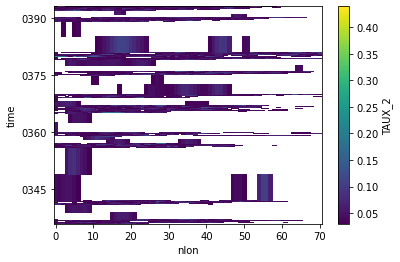

In [308]:
wwb_elnino.plot()

In [327]:
taux.ULONG.where((taux.ULAT>=-5)&(taux.ULAT<=5)&(taux.ULONG>120)&(taux.ULONG<200),drop=True).mean('nlat').compute()

<xarray.DataArray 'ULONG' (nlon: 71)>
array([120.87494651, 121.99994977, 123.12495305, 124.24995634,
       125.37495966, 126.499963  , 127.62496635, 128.74996971,
       129.87497309, 130.99997649, 132.12497989, 133.2499833 ,
       134.37498672, 135.49999015, 136.62499358, 137.74999702,
       138.87500046, 139.99999902, 141.12500734, 142.25001078,
       143.37501421, 144.50001764, 145.62502107, 146.75002449,
       147.8750279 , 149.00003131, 150.1250347 , 151.25003808,
       152.37504144, 153.50004479, 154.62504813, 155.75005145,
       156.87505475, 158.00005803, 159.12506128, 160.25006452,
       161.37506773, 162.50007091, 163.62507407, 164.75007721,
       165.87508031, 167.00008338, 168.12508642, 169.25008943,
       170.37509241, 171.50009535, 172.62509825, 173.75010112,
       174.87510395, 176.00010674, 177.12510949, 178.2501122 ,
       179.37511487, 180.50011749, 181.62512007, 182.7501226 ,
       183.87512508, 185.00012752, 186.12512991, 187.25013226,
       188.37513455, 189.50013679, 190.62513898, 191.75014111,
       192.87514319, 194.00014522, 195.12514719, 196.25014911,
       197.37515097, 198.50015278, 199.62515452])
Dimensions without coordinates: nlon

In [349]:
wwb_long

<xarray.DataArray 'TAUX_2' (time: 837, nlon: 71)>
dask.array<getitem, shape=(837, 71), dtype=float64, chunksize=(81, 71), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0336-02-08 00:00:00 ... 0392-12-21 00:00:00
    yyyymmdd  (time) int64 3360208 3360210 3360317 ... 3921219 3921220 3921221
Dimensions without coordinates: nlon

In [342]:
wwb_long = wwb_elnino.rolling(nlon=9).mean().dropna('time',how='all')

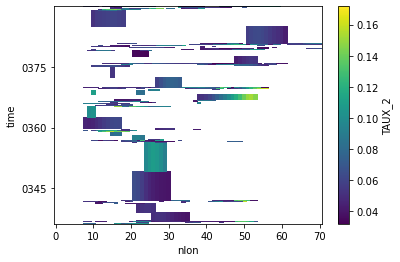

In [348]:
wwb_long.where(wwb_long.yyyymmdd.isin(traj_wind_elnino.yyyymmdd),drop=True).plot()

In [344]:
wwb_tc_filter1.rolling(nlon=9).mean().dropna('time',how='all')

<xarray.DataArray 'TAUX_2' (time: 299, nlon: 71)>
dask.array<getitem, shape=(299, 71), dtype=float64, chunksize=(39, 71), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0336-03-21 00:00:00 ... 0389-12-16 00:00:00
    yyyymmdd  (time) int64 3360321 3360322 3360323 ... 3891212 3891215 3891216
Dimensions without coordinates: nlon

In [262]:
traj_wind_elnino.yyyymmdd

<xarray.DataArray 'yyyymmdd' (nstorm: 432, steps: 65)>
array([[3360108., 3360109.,      nan, ...,      nan,      nan,      nan],
       [3360110., 3360110., 3360111., ...,      nan,      nan,      nan],
       [3360211., 3360211., 3360211., ...,      nan,      nan,      nan],
       ...,
       [3891118., 3891118., 3891119., ...,      nan,      nan,      nan],
       [3891121., 3891122., 3891122., ...,      nan,      nan,      nan],
       [3891212., 3891212., 3891212., ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
    year      (nstorm, steps) float32 336.0 336.0 nan nan ... nan nan nan nan
    month     (nstorm, steps) float32 1.0 1.0 nan nan nan ... nan nan nan nan
    day       (nstorm, steps) float32 8.0 9.0 nan nan nan ... nan nan nan nan
    lat       (nstorm, steps) float32 -14.4 -14.76 nan nan ... nan nan nan nan
    lon       (nstorm, steps) float32 125.2 126.8 nan nan ... nan nan nan nan
    yyyymmdd  (nstorm, steps) float32 3.36e+06 3.36e+06 nan nan ... nan nan nan
Dimensions without coordinates: nstorm, steps

<xarray.DataArray 'traj_data' (yyyymmdd: 299)>
array([28.612938 , 27.94566  , 36.20242  , 38.45198  , 36.91304  ,
       34.816536 , 12.01005  , 25.959824 , 28.523071 , 24.081186 ,
       33.31771  , 33.605587 , 40.370083 , 34.497707 , 17.538109 ,
       21.09047  , 37.35441  , 46.122467 , 20.139204 , 35.28444  ,
       45.002853 , 11.178434 , 22.12561  , 38.15963  , 23.509853 ,
       25.76276  , 18.116373 , 25.14067  , 25.578875 , 20.538164 ,
       37.46357  , 23.487003 , 41.332115 , 35.52551  , 18.52634  ,
       23.176397 , 36.63925  , 26.24723  , 27.527115 , 24.36487  ,
       23.850134 , 33.084637 , 40.80561  , 19.80568  , 22.163376 ,
       24.555    , 21.84496  , 24.628815 , 30.903923 , 36.982086 ,
       31.76522  , 27.704405 , 22.45726  , 34.295837 , 32.62936  ,
       23.891273 , 28.713568 , 20.60049  , 26.674952 , 27.356443 ,
       44.80181  , 33.179874 , 27.46385  , 30.494232 , 43.65626  ,
       30.811775 , 34.536064 , 41.946716 , 45.890484 , 39.826813 ,
       33.773083 , 38.70977  , 45.150623 , 37.744457 , 25.824759 ,
       25.923687 , 26.887213 , 32.513462 , 36.544815 , 50.28282  ,
       62.440567 , 19.460781 , 25.580494 , 25.246885 , 46.1884   ,
       62.93119  , 18.145082 , 39.777267 , 20.36285  , 24.70455  ,
       30.269255 , 39.70358  , 30.895727 , 28.695135 , 24.658236 ,
       20.406063 , 20.561413 , 32.07748  , 39.724228 , 58.3948   ,
...
       31.69288  , 40.383114 , 43.198036 , 46.275887 , 38.29773  ,
       21.329178 , 22.023535 , 20.90415  , 21.33143  , 21.65653  ,
       22.880337 , 39.07148  , 39.090828 , 25.217056 , 30.23884  ,
       30.25388  , 21.13529  , 22.602655 , 29.990524 , 35.227173 ,
       14.178459 , 25.87495  , 20.24614  , 14.845835 , 16.13756  ,
       16.611506 , 24.66726  , 24.53053  , 26.651852 , 24.22851  ,
       18.11926  , 31.64278  , 29.36366  , 29.65511  , 39.278927 ,
       26.77464  , 28.675165 , 28.494835 , 28.801357 , 32.36175  ,
       35.989647 , 37.790333 , 39.47425  , 26.489159 , 19.36193  ,
       25.822102 , 19.40718  , 23.661024 , 26.849047 , 20.993286 ,
       26.426495 , 29.259033 , 34.956    , 46.266617 , 35.135353 ,
       30.023237 , 35.688763 , 32.27818  , 43.5094   , 43.632324 ,
       35.167194 , 44.46423  , 48.6481   , 43.56335  , 45.890484 ,
       39.826813 , 38.70977  , 45.150623 , 37.71004  , 37.744457 ,
       32.513462 , 36.544815 , 50.28282  , 41.832813 , 30.349508 ,
       28.890894 , 27.913523 , 31.668634 , 32.067463 , 32.042118 ,
       34.8816   , 19.981335 , 30.19163  , 33.034092 , 25.580494 ,
       28.084227 , 29.143427 , 20.237442 , 40.965965 , 27.89234  ,
       21.37417  , 30.28179  , 28.296017 , 32.940495 , 32.127388 ,
       43.423706 , 30.399984 , 30.00883  , 33.216015 ], dtype=float32)
Coordinates:
  * yyyymmdd  (yyyymmdd) float64 3.36e+06 3.36e+06 ... 3.891e+06 3.891e+06

In [361]:
traj_wind_elnino

<xarray.DataArray 'traj_data' (nstorm: 432, steps: 65)>
array([[16.7673 , 17.88732,      nan, ...,      nan,      nan,      nan],
       [23.32136, 23.63883, 23.94848, ...,      nan,      nan,      nan],
       [17.19627, 16.8317 , 26.29394, ...,      nan,      nan,      nan],
       ...,
       [22.49894, 21.09306, 24.54764, ...,      nan,      nan,      nan],
       [13.22874, 18.29602, 18.26429, ...,      nan,      nan,      nan],
       [30.90023, 26.67763, 33.62209, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
    year      (nstorm, steps) float32 336.0 336.0 nan nan ... nan nan nan nan
    month     (nstorm, steps) float32 1.0 1.0 nan nan nan ... nan nan nan nan
    day       (nstorm, steps) float32 8.0 9.0 nan nan nan ... nan nan nan nan
    lat       (nstorm, steps) float32 -14.4 -14.76 nan nan ... nan nan nan nan
    lon       (nstorm, steps) float32 125.2 126.8 nan nan ... nan nan nan nan
    yyyymmdd  (nstorm, steps) float32 3.36e+06 3.36e+06 nan nan ... nan nan nan
Dimensions without coordinates: nstorm, steps

In [364]:
traj_elnino_daily = traj_wind_elnino.groupby('yyyymmdd').mean()

In [368]:
traj_elnino_daily

<xarray.DataArray 'traj_data' (yyyymmdd: 1568)>
array([16.7673  , 17.88732 , 23.480095, ..., 27.525705, 30.00883 ,
       33.216015], dtype=float32)
Coordinates:
  * yyyymmdd  (yyyymmdd) float64 3.36e+06 3.36e+06 ... 3.891e+06 3.891e+06

In [367]:
traj_elnino_daily.where(traj_elnino_daily.yyyymmdd.isin(wwb_elnino.yyyymmdd),drop=True)

<xarray.DataArray 'traj_data' (yyyymmdd: 856)>
array([16.7673   , 17.88732  , 23.480095 , 24.242147 , 20.107302 ,
       25.313047 , 28.612938 , 27.94566  , 36.20242  , 38.67606  ,
       33.295876 , 34.000153 , 20.708319 , 44.528915 , 52.749985 ,
       19.10681  , 29.08103  , 30.085522 , 25.9073   , 37.877316 ,
       42.05607  , 20.76019  , 33.047157 , 38.45198  , 36.91304  ,
       34.816536 , 35.549927 , 31.774906 , 25.337519 , 27.306396 ,
       26.553911 , 20.75151  , 14.83868  , 12.01005  , 17.0491   ,
       23.212494 , 26.307938 , 29.572346 , 40.96005  , 34.767155 ,
       15.40444  , 21.174215 , 23.46359  , 29.742964 , 29.47167  ,
       25.959824 , 28.523071 , 23.358374 , 25.74616  , 21.910583 ,
       19.887466 , 19.29342  , 23.110565 , 24.234503 , 25.032837 ,
       28.851133 , 31.129614 , 39.404213 , 24.081186 , 21.297913 ,
       24.603626 , 33.31771  , 33.605587 , 32.738533 , 35.66382  ,
       40.370083 , 34.497707 , 31.58531  , 17.538109 , 21.09047  ,
       37.35441  , 46.122467 , 35.059692 , 33.29692  , 22.301296 ,
       22.226448 , 20.139204 , 35.28444  , 45.002853 , 11.178434 ,
       22.12561  , 38.15963  , 53.05557  , 18.455246 , 23.509853 ,
       25.76276  , 18.116373 , 21.59395  , 29.295757 , 53.02502  ,
       25.14067  , 25.578875 , 41.515114 , 19.537106 , 20.538164 ,
       22.663818 , 23.854492 , 38.874332 , 30.779575 , 22.685349 ,
...
       15.94269  , 38.70977  , 45.150623 , 51.18498  , 20.85027  ,
       37.71004  , 37.744457 , 25.824759 , 27.901833 , 26.887213 ,
       31.655586 , 32.513462 , 36.544815 , 50.28282  , 62.440567 ,
       72.05795  , 29.843018 , 29.642841 , 31.892097 , 40.495304 ,
       42.575825 , 48.916473 , 41.832813 , 30.349508 , 28.890894 ,
       27.913523 , 31.668634 , 32.067463 , 32.042118 , 34.8816   ,
       31.654764 , 25.508354 , 13.03063  , 17.98569  , 18.17724  ,
       19.981335 , 30.19163  , 33.034092 , 25.64679  , 15.335505 ,
       23.576584 , 34.32167  , 25.10615  , 23.151999 , 19.460781 ,
       22.214203 , 25.580494 , 25.246885 , 19.83591  , 26.145468 ,
       30.03411  , 23.45161  , 27.582985 , 35.98126  , 26.54154  ,
       46.1884   , 62.93119  , 18.145082 , 19.654053 , 22.044376 ,
       28.084227 , 29.143427 , 20.237442 , 19.936268 , 19.32185  ,
       24.657558 , 26.886631 , 30.70701  , 19.1674   , 40.965965 ,
       20.159695 , 27.89234  , 31.367853 , 18.09931  , 19.69116  ,
       21.37417  , 30.28179  , 21.236942 , 23.247162 , 17.27769  ,
       18.603918 , 21.453293 , 22.500338 , 21.697107 , 22.75234  ,
       18.280155 , 28.338654 , 28.296017 , 32.940495 , 32.127388 ,
       43.423706 , 30.399984 , 23.601038 , 27.525705 , 30.00883  ,
       33.216015 ], dtype=float32)
Coordinates:
  * yyyymmdd  (yyyymmdd) float64 3.36e+06 3.36e+06 ... 3.891e+06 3.891e+06

In [366]:
wwb_long.yyyymmdd

<xarray.DataArray 'yyyymmdd' (time: 837)>
array([3360208, 3360210, 3360317, 3360318, 3360319, 3360320, 3360321,
       3360322, 3360323, 3360407, 3360408, 3360416, 3360522, 3360524,
       3360530, 3360531, 3360601, 3360618, 3360621, 3360714, 3360830,
       3360831, 3360901, 3360911, 3360912, 3361013, 3361014, 3361015,
       3361016, 3361019, 3361020, 3361023, 3361024, 3361026, 3361028,
       3361029, 3361030, 3361031, 3361101, 3361105, 3361108, 3361109,
       3361110, 3361225, 3361226, 3361227, 3361228, 3361229, 3361230,
       3410102, 3410103, 3410215, 3410220, 3410317, 3410318, 3410319,
       3410321, 3410328, 3410329, 3410330, 3410404, 3410405, 3410506,
       3410511, 3410519, 3410521, 3410522, 3410523, 3410603, 3410725,
       3410906, 3410911, 3410912, 3410913, 3410915, 3410916, 3410917,
       3410918, 3410921, 3410922, 3410923, 3410924, 3410925, 3410926,
       3410928, 3410929, 3411021, 3411023, 3411115, 3411117, 3411118,
       3411119, 3411120, 3411121, 3411122, 3411123, 3411124, 3411125,
       3411129, 3411206, 3411207, 3411208, 3411209, 3411216, 3411220,
       3411221, 3411226, 3411227, 3411230, 3560207, 3560208, 3560209,
       3560210, 3560211, 3560216, 3560218, 3560224, 3560225, 3560226,
       3560227, 3560228, 3560301, 3560302, 3560303, 3560304, 3560404,
       3560406, 3560407, 3560524, 3560604, 3560609, 3560610, 3560707,
       3560713, 3560714, 3560715, 3560716, 3560721, 3560722, 3560723,
...
       3891008, 3891009, 3891010, 3891013, 3891018, 3891025, 3891026,
       3891112, 3891113, 3891124, 3891125, 3891126, 3891127, 3891129,
       3891130, 3891201, 3891202, 3891203, 3891204, 3891205, 3891206,
       3891207, 3891208, 3891209, 3891210, 3891211, 3891212, 3891215,
       3891216, 3891217, 3891218, 3891219, 3891220, 3891221, 3891222,
       3891223, 3891225, 3891226, 3891227, 3891228, 3920110, 3920112,
       3920114, 3920115, 3920116, 3920117, 3920118, 3920129, 3920130,
       3920202, 3920204, 3920208, 3920213, 3920214, 3920215, 3920216,
       3920321, 3920323, 3920324, 3920325, 3920326, 3920507, 3920514,
       3920515, 3920517, 3920518, 3920520, 3920529, 3920530, 3920531,
       3920602, 3920603, 3920604, 3920607, 3920608, 3920609, 3920610,
       3920611, 3920612, 3920613, 3920616, 3920710, 3920711, 3920731,
       3920801, 3920802, 3920803, 3920804, 3920805, 3920806, 3920807,
       3920808, 3920902, 3920930, 3921001, 3921002, 3921003, 3921004,
       3921005, 3921006, 3921007, 3921008, 3921017, 3921018, 3921020,
       3921021, 3921022, 3921029, 3921030, 3921031, 3921101, 3921102,
       3921103, 3921104, 3921105, 3921108, 3921109, 3921110, 3921111,
       3921112, 3921113, 3921114, 3921115, 3921116, 3921117, 3921118,
       3921119, 3921120, 3921121, 3921213, 3921215, 3921216, 3921217,
       3921218, 3921219, 3921220, 3921221])
Coordinates:
  * time      (time) object 0336-02-08 00:00:00 ... 0392-12-21 00:00:00
    yyyymmdd  (time) int64 3360208 3360210 3360317 ... 3921219 3921220 3921221

In [ ]:
# for each WWB events in filter1, check if the event is close to the TC center
# loop over WWB filter 1, 
overlap=wwb_tc_filter1.yyyymmdd
for ic in overlap.size:
    traj_wind_elnino.isel(time=traj_wind_elnino.yyyymmdd.isin(overlap[ic])
wwb_tc_filter2 = 